### Background:  Pivot Bio runs an extensive field demonstration program to introduce farmers to our products, covering thousands of acres across the United States. Ideally, we would have an agronomist visit every farmer to address issues, but as we include more and more farmers it becomes harder and harder to visit. We have established a UAV imagery process that allows for monitoring and quality control of smaller trials, but we need a UAV based process to monitor our on-farm and commercial trials. Ideally, the system would inform Agronomists when an issue is detected, so they can contact the grower.   

### Goal: Development of a model using satellite/UAV remote sensing datasets from free repositories to detect product failure with > 60% accuracy by the V6 crop growth stage 

# Collect data from S3

In [1]:
import ftl.dw_call as dw
import boto3
from copy import deepcopy
from pathlib import Path
import os
import shutil
import glob

import pandas as pd
from pandas.errors import ParserError
import numpy as np
from datetime import datetime
from fiona.collection import DriverError
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import geopandas as gpd
from osgeo import gdal
from shapely.ops import unary_union
from shapely.geometry import Polygon
from io import BytesIO
import rasterio
import rasterio as rio
import rasterio.plot
from rasterio.transform import Affine
from rasterstats import zonal_stats
import pyproj

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

In [3]:
### We will work on protocol '22-ZEAMX-US501' first
keys = ['22-ZEAMX-US501']

### Download & Calculation: access sataellite data (plots and image) from S3; calculate 

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('pivot-uav-collab')

non_raw = []
for kw in keys:
    print(f"Accessing Keyword: {kw}")
    objects = bucket.objects.filter(
        Prefix=f'planet/{kw}',
        MaxKeys=40000
    )

    non_raw.extend([x for x in objects if '_RAW' not in x.key.upper()])
rasters = {
    x.key: x.bucket_name for x in non_raw 
    if any(s in x.key.upper() for s in ['_MULTISPECTRAL.',])
}

plots = {
    x.key: x.bucket_name for x in non_raw 
    if 'GPKG' in x.key.upper()
}

Accessing Keyword: 22-ZEAMX-US501


In [5]:
print(len(plots))
plots

30


{'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA02-5GAUL/22-ZEAMX-US501-IA02-5GAUL_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA03-5NICHO/22-ZEAMX-US501-IA03-5NICHO_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA04-5HANSE/22-ZEAMX-US501-IA04-5HANSE_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA05-5SHOOK/22-ZEAMX-US501-IA05-5SHOOK_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA06-5STORB/22-ZEAMX-US501-IA06-5STORB_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL01-5DENTO/22-ZEAMX-US501-IL01-5DENTO_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL02-5WADE/22-ZEAMX-US501-IL02-5WADE_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL03-5JONES/22-ZEAMX-US501-IL03-5JONES_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL04-5LAUX/22-ZEAMX-US501-IL04-5LAUX_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IN01-5GOHN/22-ZEAMX-US

In [6]:
print(len(rasters))
rasters

1776


{'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220602_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220603_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220609_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220613_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220614_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220616_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220617_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAM

In [3]:
def read_s3_contents(bucket_name, key):
    response = s3.Object(bucket_name, key).get()
    return response['Body'].read()

def calc_nd(band1, band2):
    return((band1 - band2) / (band1 + band2))

def multipolygon_to_polygon(geometry):
    if geometry.geom_type.lower() == 'multipolygon':
        return geometry.geoms[0]
    else:
        return geometry

In [8]:
%%time
full = []
failed = {}
for image, bucket in rasters.items():
    # get image metadata
    trial, file = image.split(r'/')[-2:]
    date = file.split(r'_')[1]
    
    # search for matching plots on trial name
    try:
        plot = [x for x in plots.keys() if trial in x][0]
    except IndexError:
        failed.update({image:'no plot (indexerror)'})
        continue
    
    # read in plots and buffer 1m inwards
    try:
        gpkg = gpd.read_file(BytesIO(read_s3_contents(bucket, plot)))
        gpkg = gpkg.dropna(axis='columns', how='all')
    except DriverError:
        failed.update({plot:'plot issue (drivererror)'})
        continue
    if not set([
        'trial_id', 'plot', 'row', 'col', 'treatment', 'geometry'
    ]).issubset(set(gpkg.columns)):
        failed.update({plot:'plot metadata issue (missing column)'})
        continue
    if gpkg.crs.axis_info[0].unit_name != 'metre':
        gpkg = gpkg.to_crs('epsg:5070')
    gpkg['geometry'] = gpkg['geometry'].apply(multipolygon_to_polygon)
    gpkg['geometry'] = gpkg.buffer(-1)
    
    # read in image
    with rio.open(BytesIO(read_s3_contents(bucket, image))) as src:
        data = src.read()
        profile = src.profile
    
    # set plot crs to image crs
    if not profile['crs'] == gpkg.crs:
        gpkg = gpkg.to_crs(profile['crs'])

    # band math
    vis = {}
    vis['ndvi'] = calc_nd(data[4], data[2])
    vis['ndre'] = calc_nd(data[4], data[3])
    try:
        ndvi = pd.DataFrame(zonal_stats(
            gpkg,
            vis['ndvi'],
            affine=profile['transform'],
            stats=['mean', 'std']
        ))
    except AttributeError:
        failed.update({image:'zonal stats issue (attributeerror)'})
        continue
    ndvi = ndvi.rename(columns={x: f'ndvi_{x}' for x in ndvi.columns})
    ndre = pd.DataFrame(zonal_stats(
        gpkg,
        vis['ndre'],
        affine=profile['transform'],
        stats=['mean', 'std']
    ))
    ndre = ndre.rename(columns={x:f'ndre_{x}' for x in ndre.columns})
    
    gpkg['flight_date'] = date
    gpkg['filename'] = plot
    gpkg['flightname'] = file
    try:
        gpkg['flight_date'] = pd.to_datetime(gpkg['flight_date'])
    except:
        pass
    out = pd.concat([gpkg, ndvi, ndre], axis=1)
    full.append(out)


Wall time: 24min 28s


In [10]:
failed

{}

In [16]:
full

[    plot        Protocol                    trial_id  col  row        PB_Trt  \
 0    206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1           NTC   
 1    101  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    1    1           NTC   
 2    203  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    9    1     2022-PVX2   
 3    104  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    4    1     2022-PVX2   
 4    106  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    6    1  2022-PBX5WAY   
 5    103  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    3    1           NTC   
 6    102  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    2    1      2022-PVX   
 7    205  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   11    1  2022-PBX5WAY   
 8    201  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    7    1      2022-PVX   
 9    105  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    5    1  2022-PBX3WAY   
 10   202  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    8    1           NTC   
 11   204  22-ZEAMX-US501  2

In [93]:
df = pd.concat(full)
df['protocol__name'] = df['trial_id'].str.rsplit('-', 2).str[0]
# there's an issue with a file flight date
# df.loc[df['flight_date']=='08172022', 'flight_date'] = '20220817'
df['flight_date'] = pd.to_datetime(df['flight_date'])
df.groupby(['protocol__name', 'trial_id']).agg({'flight_date':'nunique'})

flight_date
protocol__name trial_id                               
22-ZEAMX-US501 22-ZEAMX-US501-IA01-5FELDM           79
               22-ZEAMX-US501-IA02-5GAUL            62
               22-ZEAMX-US501-IA03-5NICHO           65
               22-ZEAMX-US501-IA04-5HANSE           73
               22-ZEAMX-US501-IA05-5SHOOK           72
               22-ZEAMX-US501-IA06-5STORB           55
               22-ZEAMX-US501-IL01-5DENTO           58
               22-ZEAMX-US501-IL02-5WADE            49
               22-ZEAMX-US501-IL03-5JONES           56
               22-ZEAMX-US501-IL04-5LAUX            66
               22-ZEAMX-US501-IN01-5GOHN            59
               22-ZEAMX-US501-IN02-5STAHL           70
               22-ZEAMX-US501-IN03-5SMITH           59
               22-ZEAMX-US501-KS01-5BIGHA           60
               22-ZEAMX-US501-MI01-5GENTZ           55
               22-ZEAMX-US501-MI02-5MORSE           54
               22-ZEAMX-US501-MN01-5DOMNI           43
               22-ZEAMX-US501-MN03-5RUDNI           51
               22-ZEAMX-US501-MO01-5DYE             70
               22-ZEAMX-US501-MS01-5ARRIN           28
               22-ZEAMX-US501-MS02-5HURRI           42
               22-ZEAMX-US501-MS03-5HURRI           48
               22-ZEAMX-US501-NC01-5WILLI           48
               22-ZEAMX-US501-ND01-5PETER           63
               22-ZEAMX-US501-NE02-5KOEHN           61
               22-ZEAMX-US501-OH01-5BOND            36
               22-ZEAMX-US501-OH02-5RUPP            54
               22-ZEAMX-US501-OK01-5ISAAC           78
               22-ZEAMX-US501-SD02-5ALVER           74
               22-ZEAMX-US501-TX01-5POHNE           88

In [13]:
df.groupby(['protocol__name']).agg({'trial_id':'nunique'})

trial_id
protocol__name          
22-ZEAMX-US501        30

In [343]:
# df.to_csv('Planet501_info.csv',index=False)

In [18]:
df.head()

plot        Protocol                    trial_id  col  row        PB_Trt  \
0   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1           NTC   
1   101  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    1    1           NTC   
2   203  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    9    1     2022-PVX2   
3   104  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    4    1     2022-PVX2   
4   106  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    6    1  2022-PBX5WAY   

       Fert_trt  treatment                                           geometry  \
0        N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
1        N:100%          1  POLYGON ((-93.62041 41.86560, -93.62042 41.865...   
2  N:100%-50 LB          4  POLYGON ((-93.62043 41.86429, -93.62044 41.864...   
3  N:100%-50 LB          4  POLYGON ((-93.62042 41.86511, -93.62042 41.865...   
4  N:100%-50 LB          6  POLYGON ((-93.62043 41.86478, -93.62043 41.864...   

  flight_date                                           filename  \
0  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
2  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
3  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
4  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   

                                          flightname  ndvi_mean  ndvi_std  \
0  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.260044  0.129612   
2  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.303751  0.125496   
3  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.297243  0.133003   
4  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.318133  0.155143   

   ndre_mean  ndre_std  OBJECTID  Shape_Leng  Shape_Le_1  Shape_Length  \
0   0.154118  0.131604       NaN         NaN         NaN           NaN   
1   0.129890  0.110995       NaN         NaN         NaN           NaN   
2   0.161806  0.090118       NaN         NaN         NaN           NaN   
3   0.127028  0.155873       NaN         NaN         NaN           NaN   
4   0.152862  0.140535       NaN         NaN         NaN           NaN   

   Shape_Area  SHAPE_LENG PROTOCOL PB_TRT FERT_TRT  SHAPE_LE_1  Name Fert_Trt  \
0         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
1         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
2         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
3         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
4         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   

   protocol__name  
0  22-ZEAMX-US501  
1  22-ZEAMX-US501  
2  22-ZEAMX-US501  
3  22-ZEAMX-US501  
4  22-ZEAMX-US501

In [96]:
df_new=df.iloc[:,0:18]

In [31]:
df_new.head(2)

plot        Protocol                    trial_id  col  row PB_Trt Fert_trt  \
0   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   N:100%   
1   101  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    1    1    NTC   N:100%   

   treatment                                           geometry flight_date  \
0          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...  2022-06-01   
1          1  POLYGON ((-93.62041 41.86560, -93.62042 41.865...  2022-06-01   

                                            filename  \
0  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   

                                          flightname  ndvi_mean  ndvi_std  \
0  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.260044  0.129612   

   ndre_mean  ndre_std  
0   0.154118  0.131604  
1   0.129890  0.110995

###  Match the growth stage

In [19]:
### read stage data
data = pd.read_csv('22-ZEAMX-US501 metadata and growthstage date estimates.csv')
data.head(2)

trial_id  year        protocol experiment_name  \
0  22-ZEAMX-US501-IA01-5FELDM  2022  22-ZEAMX-US501       FTR001148   
1   22-ZEAMX-US501-IA02-5GAUL  2022  22-ZEAMX-US501       FTR001149   

                   trial_id.1 planting_date harvest_date  \
0  22-ZEAMX-US501-IA01-5FELDM       5/30/22      11/2/22   
1   22-ZEAMX-US501-IA02-5GAUL       5/24/22     10/31/22   

                 gps_center qc_score  qc_notes  estimated_harvest_date  \
0  41.86343116,-93.62011716   Yellow       NaN                   False   
1  42.64824296,-91.39564924   Yellow       NaN                   False   

       V0       VE       V1       V2       V3       V4       V5       V6  \
0  6/4/22  6/11/22  6/14/22  6/17/22  6/20/22  6/22/22  6/25/22  6/29/22   
1  6/1/22  6/11/22  6/14/22  6/17/22  6/21/22  6/24/22  6/27/22   7/1/22   

       V7      V8       V9      V10      V11      V12       VT       R1  \
0  7/1/22  7/5/22   7/7/22  7/10/22  7/12/22  7/23/22  7/29/22  8/20/22   
1  7/4/22  7/7/22  7/10/22  7/13/22  7/17/22  7/28/22   8/4/22  8/30/22   

        R2       R3       R4       R5        R6      R6+  
0  8/28/22   9/5/22  9/16/22  10/9/22  10/12/22  11/3/22  
1   9/8/22  9/18/22  10/4/22  11/1/22       NaN      NaN

In [20]:
filtered_data= data.iloc[:,[0]+[8]+list(range(11,33))]

### transfer the string to datetime
stage=filtered_data.iloc[:,2:24].applymap(lambda x: datetime.strptime(x, "%m/%d/%y").date() if not pd.isna(x) else x)
stage['trial_id']=filtered_data['trial_id']
stage['qc_score']=filtered_data['qc_score']

In [49]:
trials=df_new['trial_id'].tolist()
dates=df_new['flight_date'].tolist()
growth_stages=[]

for i in range(len(trials)):
    ### get trail_id and image date
    trial_id = str(trials[i])
    date_string = str(dates[i]).split()[0]
    date_format = "%Y-%m-%d"
    
    ### match the exact trail
    select=stage[stage['trial_id'] == trial_id]
    
    ### match the date and save
    growth_stage=select.iloc[0,0:-2].sub(datetime.strptime(date_string, date_format).date()).abs().idxmin()
    growth_stages.append(growth_stage)

In [50]:
df_new['stage']=growth_stages

In [40]:
df_new['stage'].unique()

array(['V0', 'VE', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V10', 'V11',
       'V12', 'VT', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R6+', 'V9', 'V8'],
      dtype=object)

### Get the yield data

In [78]:
all_yield = pd.read_csv('biomass_measurements__yield_bu_acre.csv')
all_yield.head(3)

protocol__name        experiment__trial_id  plot__lookup_key  \
0  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM             101.0   
1  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM             102.0   
2  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM             103.0   

                 experiment__gps_center       value  
0  41.86343116382189,-93.62011715769768  259.772300  
1  41.86343116382189,-93.62011715769768  254.944092  
2  41.86343116382189,-93.62011715769768  245.545464

In [79]:
### extract the yield column and GPS center of the plot
all_yield.columns=['Protocol','trial_id','plot','GPS_center','yield']
all_yield.head(3)

Protocol                    trial_id   plot  \
0  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM  101.0   
1  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM  102.0   
2  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM  103.0   

                             GPS_center       yield  
0  41.86343116382189,-93.62011715769768  259.772300  
1  41.86343116382189,-93.62011715769768  254.944092  
2  41.86343116382189,-93.62011715769768  245.545464

In [80]:
df_merge3=pd.merge(df_new,all_yield,on=['trial_id','plot'])
# df_merge3.to_csv('merged501_data.csv',index=False)
df_merge3

plot      Protocol_x                    trial_id  col  row PB_Trt  \
0       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
1       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
2       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
3       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
4       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
...     ...             ...                         ...  ...  ...    ...   
20521   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20522   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20523   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20524   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20525   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   

      Fert_trt  treatment                                           geometry  \
0       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
1       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
2       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
3       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
4       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
...        ...        ...                                                ...   
20521   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20522   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20523   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20524   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20525   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   

      flight_date                                           filename  \
0      2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1      2022-06-02  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
2      2022-06-03  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
3      2022-06-09  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
4      2022-06-13  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
...           ...                                                ...   
20521  2022-10-25  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20522  2022-10-26  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20523  2022-10-30  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20524  2022-10-31  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20525  2022-11-02  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   

                                              flightname  ndvi_mean  ndvi_std  \
0      22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1      22-ZEAMX-US501-IA01-5FELDM_20220602_ANALYTIC5B...   0.390106  0.088408   
2      22-ZEAMX-US501-IA01-5FELDM_20220603_ANALYTIC5B...   0.390642  0.053602   
3      22-ZEAMX-US501-IA01-5FELDM_20220609_ANALYTIC5B...   0.386687  0.039191   
4      22-ZEAMX-US501-IA01-5FELDM_20220613_ANALYTIC5B...   0.501900  0.102390   
...                                                  ...        ...       ...   
20521  22-ZEAMX-US501-TX01-5POHNE_20221025_ANALYTIC5B...   0.294094  0.256510   
20522  22-ZEAMX-US501-TX01-5POHNE_20221026_ANALYTIC5B...   0.304760  0.211524   
20523  22-ZEAMX-US501-TX01-5POHNE_20221030_ANALYTIC5B...   0.319794  0.190175   
20524  22-ZEAMX-US501-TX01-5POHNE_20221031_ANALYTIC5B...   0.375471  0.180464   
20525  22-ZEAMX-US501-TX01-5POHNE_20221102_ANALYTIC5B...   0.269678  0.138529   

       ndre_mean  ndre_std stage      Protocol_y  \
0       0.154118  0.131604    V0  22-ZEAMX-US501   
1       0.373614  0.090695    V0  22-ZEAMX-US501   
2       0.347209  0.070734    V0  22-ZEAMX-US501   
3       0.311988  0.042532    VE  22-ZEAMX-US501   
4       0.235274  0.112921    V1  2

In [65]:
df_merge3[['treatment', 'Fert_trt', 'PB_Trt']].value_counts().sort_index()

treatment  Fert_trt      PB_Trt      
1          N:100%        NTC             3110
2          N:100%-50 LB  2022-PVX        3110
3          N:100%-50 LB  NTC             3110
4          N:100%-50 LB  2022-PVX2       3110
5          N:100%-50 LB  2022-PBX3WAY    3110
6          N:100%-50 LB  2022-PBX5WAY    3110
dtype: int64

In [68]:
### no image
### 22-ZEAMX-US501-TN01-5VEREL

### no field data
### 22-ZEAMX-US501-NC01-5WILLI

### Drop NaN values

In [49]:
# df_load=pd.read_csv('merged501_data.csv')
# df_merge3=df_load.copy()

In [6]:
df_merge3.columns

Index(['plot', 'Protocol_x', 'trial_id', 'col', 'row', 'PB_Trt', 'Fert_trt',
       'treatment', 'geometry', 'flight_date', 'filename', 'flightname',
       'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage', 'Protocol_y',
       'GPS_center', 'yield'],
      dtype='object')

In [7]:
df_merge3.head(2) 

plot      Protocol_x                    trial_id  col  row PB_Trt Fert_trt  \
0   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   N:100%   
1   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   N:100%   

   treatment                                           geometry flight_date  \
0          1  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-01   
1          1  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-02   

                                            filename  \
0  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   

                                          flightname  ndvi_mean  ndvi_std  \
0  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1  22-ZEAMX-US501-IA01-5FELDM_20220602_ANALYTIC5B...   0.390106  0.088408   

   ndre_mean  ndre_std stage      Protocol_y  \
0   0.154118  0.131604    V0  22-ZEAMX-US501   
1   0.373614  0.090695    V0  22-ZEAMX-US501   

                             GPS_center       yield  
0  41.86343116382189,-93.62011715769768  255.082905  
1  41.86343116382189,-93.62011715769768  255.082905

In [52]:
df_all=df_merge3[['plot','trial_id','treatment','geometry','flight_date','GPS_center','ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std','stage',
       'yield']]

df_all['geometry']=df_all['geometry'].apply(lambda x: wkt.loads(x) if x else None)

print(df_all.shape)

(20526, 12)


In [53]:
df_merge3[df_merge3.ndvi_mean.notnull()].shape 

(20131, 20)

In [54]:
df_all.isnull().sum()

plot             0
trial_id         0
treatment        0
geometry         0
flight_date      0
GPS_center       0
ndvi_mean      395
ndvi_std       395
ndre_mean      395
ndre_std       395
stage            0
yield            0
dtype: int64

In [17]:
print(df_all[df_all.ndvi_mean.isnull()].shape)
images_with_nan_list=df_all[df_all.ndvi_mean.isnull()]
images_with_nan_list.to_csv('images_with_nan_list.csv',index=None)

(395, 11)


In [18]:
df_all[df_all['ndvi_mean'].isnull()].trial_id.unique()

array(['22-ZEAMX-US501-IA03-5NICHO', '22-ZEAMX-US501-IA04-5HANSE',
       '22-ZEAMX-US501-IA06-5STORB', '22-ZEAMX-US501-IL01-5DENTO',
       '22-ZEAMX-US501-IL03-5JONES', '22-ZEAMX-US501-IL04-5LAUX',
       '22-ZEAMX-US501-IN01-5GOHN', '22-ZEAMX-US501-IN03-5SMITH',
       '22-ZEAMX-US501-MS01-5ARRIN', '22-ZEAMX-US501-MS03-5HURRI',
       '22-ZEAMX-US501-ND01-5PETER', '22-ZEAMX-US501-OK01-5ISAAC',
       '22-ZEAMX-US501-TX01-5POHNE'], dtype=object)

In [55]:
df_all = df_all.dropna()

In [234]:
df_all.isnull().sum()

plot          0
trial_id      0
treatment     0
geometry      0
GPS_center    0
ndvi_mean     0
ndvi_std      0
ndre_mean     0
ndre_std      0
stage         0
yield         0
dtype: int64

In [56]:
df_all.shape

(20131, 12)

In [57]:
df_yield=df_all.copy()
df_yield=df_yield.groupby(['trial_id','treatment']).agg({'yield':'mean'})
df_yield=df_v3_get.reset_index()

In [59]:
count_df.to_csv('501_treatment.csv',index=False)

In [62]:
df_yield.groupby(['treatment'])['Identify'].count()

treatment
1    20
2    20
3    20
4    20
5    20
6    20
Name: Identify, dtype: int64

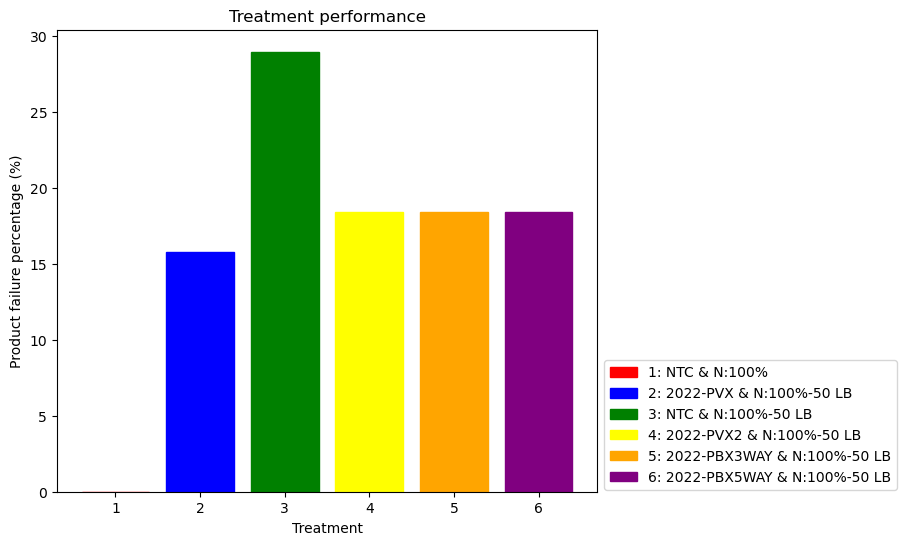

In [58]:
trials=df_yield['trial_id'].tolist()
yields=df_yield['yield'].tolist()

Identifys=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_yield[(df_yield['trial_id'] == trail_id) & (df_yield['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0

    Identifys.append(check)
    
    
df_yield['Identify'] = Identifys

count_df = df_yield.groupby(['treatment'])['Identify'].sum().reset_index()
count_df['Percentage'] = (count_df['Identify'] / count_df['Identify'].sum()) * 100

type_meanings = {'1': 'NTC & N:100%', '2': '2022-PVX & N:100%-50 LB', '3': 'NTC & N:100%-50 LB', '4': '2022-PVX2 & N:100%-50 LB', '5': '2022-PBX3WAY & N:100%-50 LB', '6': '2022-PBX5WAY & N:100%-50 LB'}
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']


plt.figure(figsize=(8, 6))
bars = plt.bar(count_df['treatment'], count_df['Percentage'])

for i, bar in enumerate(bars):
    bar.set_color(colors[i])
    
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = [f"{type_}: {meaning}" for type_, meaning in type_meanings.items()]
plt.legend(legend_handles, legend_labels,loc='upper left', bbox_to_anchor=(1, 0.3))

plt.xlabel('Treatment')
plt.ylabel('Product failure percentage (%)')
plt.title('Treatment performance')
plt.subplots_adjust(right=0.8)
plt.show()

### Extract amplitude information

In [24]:
####### after downloading all Hyp3 images, we need to project the UTM to WGS84 coordiante system.
################################################################################################################

### folder to store the downloaded unzip files
source_folder = r"/project/xhu/xiao/work/data/"

### output folder
destination_folder = r"/project/xhu/xiao/work/project_tif"

# Get the list of folders in the source directory
folders = os.listdir(source_folder)

# Loop through each folder
for folder in folders:
    folder_path = os.path.join(source_folder, folder)

    # Check if the item is a directory
    if os.path.isdir(folder_path):

        # Get the list of TIFF files in the current folder
        tiff_files = [file for file in os.listdir(folder_path) if file.endswith(".tif")]

        # Loop through each TIFF file in the current folder
        for tiff_file in tiff_files:
            tiff_file_path = os.path.join(folder_path, tiff_file)

            # Check if the file name contains VH or VV as we consider both single and dual polarization
            if "VH" in tiff_file or "VV" in tiff_file:

                # Open the input dataset
                src_ds = gdal.Open(tiff_file_path)

                # Get the UTM zone from the source dataset's coordinate reference system (CRS)
                utm_zone = int(src_ds.GetProjection().split('"')[-2])
                

                # Define the target EPSG code for WGS 84
                target_epsg = int(4326)
                file_prefix=tiff_file.split('.')[0]
                # Path to the output warped TIFF file
                output_file = os.path.join(destination_folder, f"{file_prefix}_project.tif")

                # Reproject and save the output dataset
                gdal.Warp(output_file, src_ds, dstSRS=f'EPSG:{target_epsg}')

                # Close the datasets
                src_ds = None

In [25]:
####### Due to the large image, we better cut the image to the trial scale after the projection.
################################################################################################################

### folder to store the projected images
path=r"/project/xhu/xiao/work/project_tif/"

### folder to store the cut images
output_folder=r"/project/xhu/xiao/work/cut_tif/"

df=pd.read_csv('Trial_id_Hyp3_image.csv')

trials=df.trial_id.tolist()
images=df.HyP3_image.tolist()
left=df.left.tolist()
right=df.right.tolist()
low=df.lower.tolist()
up=df.upper.tolist()

for i in range(len(images)):
    image=images[i].split(".")[0]
    trial=trials[i]
    clip_window=[left[i],low[i],right[i],up[i]]
#     print(trial,clip_window)

    vh_file=image+'_VH_project.tif'
    vh_file_path=os.path.join(path,vh_file)
    vv_file=image+'_VV_project.tif'
    vv_file_path=os.path.join(path,vv_file)

    # clip the tiff for both VV and VH
    vh_prefix=trial+"_VH"
    src_ds = gdal.Open(vh_file_path)
    output_file = os.path.join(output_folder, f"{vh_prefix}.tif")
    gdal.Warp(output_file, src_ds, outputBounds=clip_window)
    src_ds = None

    vv_prefix=trial+"_VV"
    src_ds = gdal.Open(vv_file_path)
    output_file = os.path.join(output_folder, f"{vv_prefix}.tif")
    gdal.Warp(output_file, src_ds, outputBounds=clip_window)
    src_ds = None

In [13]:
####### RESAMPLE THE IMAGE TO FINER RESOLUTION
################################################################################################################

# ### folder to store the cut images
input_path = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif\stage3"

# ### folder to store the resample images
output_path= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif\stage31"

for file in os.listdir(input_path):
    
    file_path=os.path.join(input_path,file)

    src = rasterio.open(file_path)

    # Calculate the new dimensions and resolution
    new_resolution = (0.00001, -0.00001)  # New resolution in meters
    new_width = src.width * src.transform.a / new_resolution[0]
    new_height = src.height * src.transform.e / new_resolution[1]

    # Create the output TIFF file with the new dimensions and resolution
    
#     output_file = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif2\output.tif"

    
    prefix=file.split(".")[0]
    output_file = os.path.join(output_path, f"{prefix}_resample.tif")
    
    
    dst_transform = Affine(new_resolution[0], 0, src.transform.c, 0, new_resolution[1], src.transform.f)
    dst_profile = src.profile
    dst_profile.update(transform=dst_transform, width=int(new_width), height=int(new_height))

    # Perform the resampling
    with rasterio.open(output_file, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src.crs,  # Assuming the same CRS
                resampling=rasterio.enums.Resampling.bilinear
            )

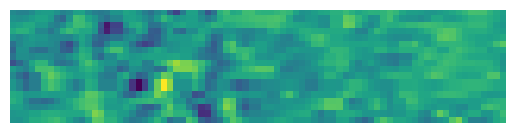

In [66]:
# Show an example of the resampled image
tif_file_path = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif\22-ZEAMX-US501-IA01-5FELDM_VH.tif"
tif_dataset = gdal.Open(tif_file_path)
tif_image = tif_dataset.ReadAsArray()
tif_dataset = None
plt.imshow(tif_image)
plt.axis('off')  # Optional: turn off axis labels
plt.show()

In [15]:
df1=df_all.copy()
print(df1.shape)
df1.head(1)

(20131, 12)


plot                    trial_id  treatment  \
0   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                            geometry flight_date  \
0  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-01   

                             GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
0  41.86343116382189,-93.62011715769768    0.32964   0.12684   0.154118   

   ndre_std stage       yield  
0  0.131604    V0  255.082905

In [6]:
from affine import Affine
import rasterio
from rasterio.mask import mask
import shapely.wkt
from shapely.geometry import box

In [14]:
def extract_statistics(image_path, polygon):
    stats = zonal_stats(polygon, image_path, stats=['mean', 'median', 'std'])
    mean_value = stats[0]['mean']
    median_value = stats[0]['median']
    std_value = stats[0]['std']
    return mean_value, median_value, std_value

In [16]:
input_tif_folder= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif\stage31"

cnt=0

######
for index, row in df1.iterrows():
    cnt+=1
    print(cnt)
    
    id_value = row['trial_id']
    image_path_VH = os.path.join(input_tif_folder,f'{id_value}_VH_resample.tif')
    image_path_VV = os.path.join(input_tif_folder,f'{id_value}_VV_resample.tif')

    # Check if the TIF image exists
    if os.path.exists(image_path_VH) and os.path.exists(image_path_VV):
        # Extract the polygon from the 'geometry' column
        polygon = row['geometry']

        # Extract the statistics from the image within the polygon
        mean_vh, median_vh, std_vh = extract_statistics(image_path_VH, polygon)
        mean_vv, median_vv, std_vv = extract_statistics(image_path_VH, polygon)

        # Update the dataframe with the statistics
        df1.at[index, 'mean_vh'] = mean_vh
        df1.at[index, 'median_vh'] = median_vh
        df1.at[index, 'std_vh'] = std_vh
        df1.at[index, 'mean_vv'] = mean_vv
        df1.at[index, 'median_vv'] = median_vv
        df1.at[index, 'std_vv'] = std_vv
    else:
        # TIF image doesn't exist, set the values as NaN
        df1.at[index, 'mean_vh'] = np.nan
        df1.at[index, 'median_vh'] = np.nan
        df1.at[index, 'std_vh'] = np.nan
        df1.at[index, 'mean_vv'] = np.nan
        df1.at[index, 'median_vv'] = np.nan
        df1.at[index, 'std_vv'] = np.nan

# Save the updated dataframe
# df.to_csv('output.csv', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285


3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927


5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566


7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712


9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351


10659
10660
10661
10662
10663
10664
10665
10666
10667
10668
10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
1082

12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
1219

13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507
13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
13520
13521
13522
13523
13524
13525
13526
13527
13528
13529
13530
13531
13532
13533
13534
13535
13536
13537
13538
13539
13540
13541
13542
13543
13544
13545
13546
13547
13548
13549
13550
13551
13552
13553
13554
13555
13556
1355

14893
14894
14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
1505

17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
1743

19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
19306
19307
19308
19309
19310
19311
19312
19313
19314
19315
19316
19317
19318
19319
19320
1932

In [17]:
df1.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'flight_date',
       'GPS_center', 'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage',
       'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv',
       'std_vv'],
      dtype='object')

### add weather - precipitation

In [18]:
### load the downloaded weather station data
weather=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\weather\station_weather.csv')

In [19]:
weather.head(2)

STATION                     NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  US1IAST0048  BETTENDORF 1.6 W, IA US  41.56502  -90.50767      211.8   
1  US1IAST0048  BETTENDORF 1.6 W, IA US  41.56502  -90.50767      211.8   

         DATE  PRCP PRCP_ATTRIBUTES state  
0  2022-05-11   0.0             ,,N    IA  
1  2022-05-23   0.0             ,,N    IA

In [239]:
df1['flight_date']=df_merge3[df_merge3.ndvi_mean.notnull()]['flight_date']

In [20]:
df1.head(2)

plot                    trial_id  treatment  \
0   206  22-ZEAMX-US501-IA01-5FELDM          1   
1   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                            geometry flight_date  \
0  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-01   
1  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-02   

                             GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
0  41.86343116382189,-93.62011715769768   0.329640  0.126840   0.154118   
1  41.86343116382189,-93.62011715769768   0.390106  0.088408   0.373614   

   ndre_std stage       yield   mean_vh  median_vh    std_vh   mean_vv  \
0  0.131604    V0  255.082905 -22.67967 -22.521034  2.195223 -22.67967   
1  0.090695    V0  255.082905 -22.67967 -22.521034  2.195223 -22.67967   

   median_vv    std_vv  
0 -22.521034  2.195223  
1 -22.521034  2.195223

In [21]:
# Convert the flight date column to datetime
df1['flight_date'] = pd.to_datetime(df1['flight_date']).dt.date
weather['DATE'] = pd.to_datetime(weather['DATE']).dt.date

###  Select stage V3 to simplify the dataset

In [22]:
# df_v3=df_all[df_all.stage=='V3']
df_v3=df1[df1.stage=='V3']

In [23]:
print(df_v3.shape)
df_v3.head(2)

(382, 18)


plot                    trial_id  treatment  \
9    206  22-ZEAMX-US501-IA01-5FELDM          1   
10   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry flight_date  \
9   POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-20   
10  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-21   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
9   41.86343116382189,-93.62011715769768   0.323745  0.049501   0.262732   
10  41.86343116382189,-93.62011715769768   0.248651  0.105270   0.127752   

    ndre_std stage       yield   mean_vh  median_vh    std_vh   mean_vv  \
9   0.044916    V3  255.082905 -22.67967 -22.521034  2.195223 -22.67967   
10  0.060016    V3  255.082905 -22.67967 -22.521034  2.195223 -22.67967   

    median_vv    std_vv  
9  -22.521034  2.195223  
10 -22.521034  2.195223

In [51]:
from shapely.geometry import Polygon,Point
from shapely import wkt

In [24]:
def find_closest_point_to_centroid(polygon_geom, points_df):
    # Extract the polygon geometry from the DataFrame
#     polygon_geom = polygon_df['geometry'].iloc[0]

    # Calculate the centroid of the polygon
    centroid = polygon_geom.centroid

    closest_point = None
    min_distance = float('inf')

    # Iterate through the DataFrame of points
    for _, point in points_df.iterrows():
        point_lat = point['LATITUDE']
        point_lon = point['LONGITUDE']
        rain_value = point['PRCP']

        # Create a Shapely Point object from the latitude and longitude
        point_geom = Point(point_lon, point_lat)

        # Calculate the distance between the point and the centroid
        distance = centroid.distance(point_geom)

        # Update the closest point and rain value if a closer point is found
        if distance < min_distance:
            min_distance = distance
            closest_point = point
            closest_point['PRCP'] = rain_value

    return closest_point

In [27]:
# df_v3['geometry']=df_v3['geometry'].apply(lambda x: wkt.loads(x) if x else None)
cnt=0

for index, row in df_v3.iterrows():
    cnt+=1
    print(cnt)
    # Extract ID, geometry, and flight date from the current row
    ID = row['trial_id']
    geometry = row['geometry']
    flight_date = row['flight_date']
#     print(flight_date)

    # Filter the weather archive dataframe based on the flight date
    filtered_weather_df = weather[weather['DATE'] == flight_date]
    
    # Find the point closest to the centroid of the polygon
    if not filtered_weather_df.empty:
        closest_point = find_closest_point_to_centroid(geometry, filtered_weather_df)

        # Retrieve the rain and elevation values for the closest weather station
        closest_station_rain = closest_point['PRCP']
        closest_station_rain_5d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],5)
        closest_station_rain_10d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],10)
        closest_station_rain_15d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],15)
#         closest_station_elevation = closest_point['ELEVATION']

        # Add the rain and elevation values as new columns in the original dataframe
        df_v3.at[index, 'closest_station_rain'] = closest_station_rain
        df_v3.at[index, 'closest_station_rain_5d'] = closest_station_rain_5d
        df_v3.at[index, 'closest_station_rain_10d'] = closest_station_rain_10d
        df_v3.at[index, 'closest_station_rain_15d'] = closest_station_rain_15d
#         df_v3.at[index, 'closest_station_elevation'] = closest_station_elevation
    else:
#         print(index,ID,flight_date)
        df_v3.at[index, 'closest_station_rain'] = np.nan
        df_v3.at[index, 'closest_station_rain_5d'] = np.nan
        df_v3.at[index, 'closest_station_rain_10d'] = np.nan
        df_v3.at[index, 'closest_station_rain_15d'] = np.nan
#         df_v3.at[index, 'closest_station_elevation'] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [625]:
df_v3.head(2)

plot                    trial_id  treatment  \
9    206  22-ZEAMX-US501-IA01-5FELDM          1   
10   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry  \
9   POLYGON ((-93.62044187504478 41.86379593747736...   
10  POLYGON ((-93.62044187504478 41.86379593747736...   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
9   41.86343116382189,-93.62011715769768   0.323745  0.049501   0.262732   
10  41.86343116382189,-93.62011715769768   0.248651  0.105270   0.127752   

    ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
9   0.044916    V3  255.082905 -22.621263 -22.445223  2.110355 -22.621263   
10  0.060016    V3  255.082905 -22.621263 -22.445223  2.110355 -22.621263   

    median_vv    std_vv flight_date  closest_station_rain  \
9  -22.445223  2.110355  2022-06-20                   0.0   
10 -22.445223  2.110355  2022-06-21                   0.0   

    closest_station_rain_5d  closest_station_rain_10d  \
9                      0.13                      0.15   
10                     0.13                      0.13   

    closest_station_rain_15d  
9                       0.61  
10                      0.61

In [626]:
df_v3.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'GPS_center', 'ndvi_mean',
       'ndvi_std', 'ndre_mean', 'ndre_std', 'stage', 'yield', 'mean_vh',
       'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 'flight_date',
       'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d'],
      dtype='object')

In [28]:
df_v3_get=df_v3.groupby(['trial_id','treatment']).agg({'ndvi_mean':'mean','ndvi_std':'mean','ndre_mean':'mean','ndre_std':'mean','yield':'mean',
                                             'mean_vh':'mean','median_vh':'mean', 'std_vh':'mean', 'mean_vv':'mean', 'median_vv':'mean', 'std_vv':'mean',
                                             'closest_station_rain':'mean','closest_station_rain_5d':'mean','closest_station_rain_10d':'mean',
                                             'closest_station_rain_15d':'mean',
                                             'geometry': unary_union})
df_v3_get=df_v3_get.reset_index()

In [251]:
# df_v3_get[df_v3_get.mean_vh.isnull()].groupby('trial_id').agg({'treatment':'count'})
# df_v3_get.isnull().sum()

## EDA

#### Add latitude and longitude as features

In [30]:
get_centroid=df_v3_get[['geometry']]
gdf = gpd.GeoDataFrame(get_centroid, geometry='geometry')
# Compute the centroid of each polygon
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroid
df_v3_get['latitude']=gdf.centroid.y
df_v3_get['longitude'] = gdf.centroid.x

In [31]:
df_v3_get['longitude']=df_v3_get['longitude']+360

#### NDRE and NDVI

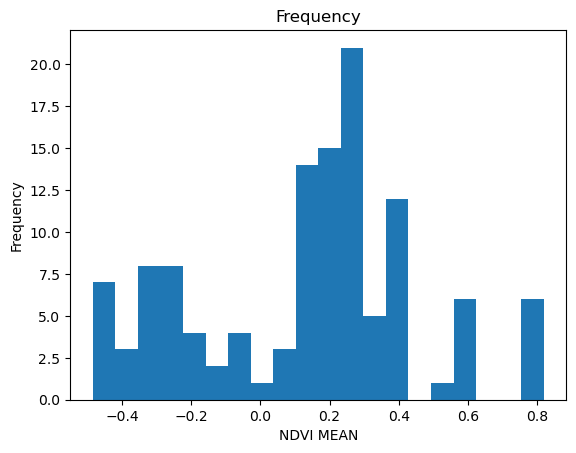

In [32]:
df_v3_get.ndvi_mean.plot(kind='hist',bins=20)
plt.xlabel('NDVI MEAN')
plt.title('Frequency')
plt.show()

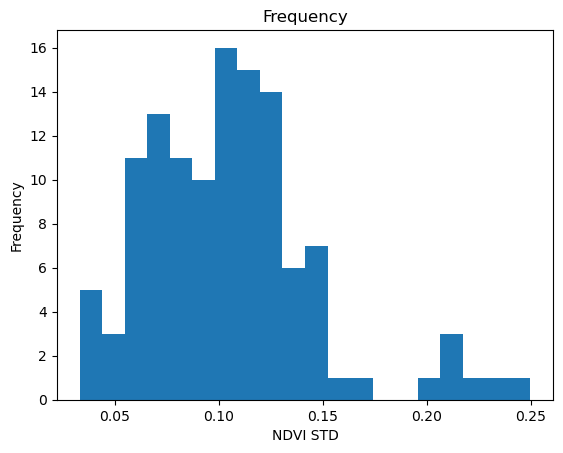

In [33]:
df_v3_get.ndvi_std.plot(kind='hist',bins=20)
plt.xlabel('NDVI STD')
plt.title('Frequency')
plt.show()

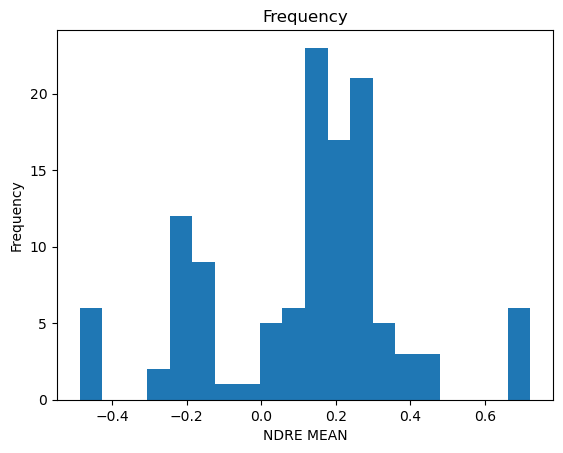

In [34]:
df_v3_get.ndre_mean.plot(kind='hist',bins=20)
plt.xlabel('NDRE MEAN')
plt.title('Frequency')
plt.show()

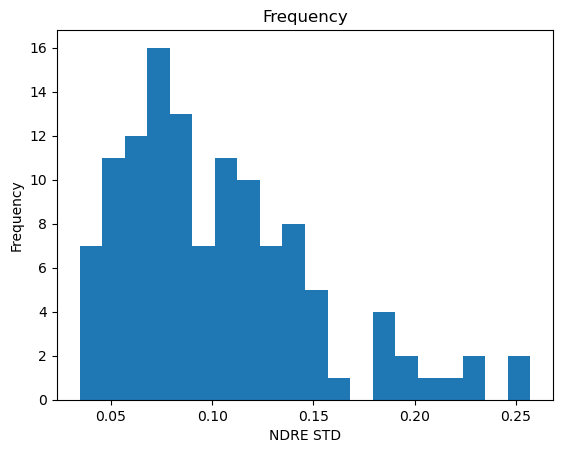

In [35]:
df_v3_get.ndre_std.plot(kind='hist',bins=20)
plt.xlabel('NDRE STD')
plt.title('Frequency')
plt.show()

In [36]:
scaler = MinMaxScaler()

df_v3_get['norm_ndvi_mean'] = scaler.fit_transform(df_v3_get[['ndvi_mean']])
df_v3_get['norm_ndvi_std'] = scaler.fit_transform(df_v3_get[['ndvi_std']].values)
df_v3_get['norm_ndre_mean'] = scaler.fit_transform(df_v3_get[['ndre_mean']].values)
df_v3_get['norm_ndre_std'] = scaler.fit_transform(df_v3_get[['ndre_std']].values)

#### treatment

In [37]:
treat_encoder = OneHotEncoder(handle_unknown='ignore')
treat_onehot=treat_encoder.fit_transform(df_v3_get[['treatment']])
treatments=pd.DataFrame(treat_onehot.toarray())

In [38]:
all_treatments=treat_encoder.categories_[0]
for i in range(len(all_treatments)):
    df_v3_get[str(all_treatments[i])]=treatments.iloc[:,i]

In [39]:
trials=df_v3_get['trial_id'].tolist()
yields=df_v3_get['yield'].tolist()

Identifys=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v3_get[(df_v3_get['trial_id'] == trail_id) & (df_v3_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0
    
    Identifys.append(check)

In [40]:
df_v3_get['Identify'] = Identifys

#### Get more features - compare with treatment 1 condition

In [41]:
df_v3_get['ndvi_mean__diff'] = df_v3_get.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_v3_get['ndvi_std_diff'] = df_v3_get.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_v3_get['ndre_mean_diff'] = df_v3_get.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_v3_get['ndre_std_diff'] = df_v3_get.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [42]:
df_v3_get['mean_amp']=(df_v3_get['mean_vh']+df_v3_get['mean_vv'])/2
df_v3_get['std_amp']=(df_v3_get['std_vh']+df_v3_get['std_vv'])/2

df_v3_get['mean_vh_diff'] = df_v3_get.groupby('trial_id')['mean_vh'].transform(lambda x: x - x.iloc[0])
df_v3_get['median_vh_diff'] = df_v3_get.groupby('trial_id')['median_vh'].transform(lambda x: x - x.iloc[0])
df_v3_get['std_vh_diff'] = df_v3_get.groupby('trial_id')['std_vh'].transform(lambda x: x - x.iloc[0])
df_v3_get['mean_vv_diff'] = df_v3_get.groupby('trial_id')['mean_vv'].transform(lambda x: x - x.iloc[0])
df_v3_get['median_vv_diff'] = df_v3_get.groupby('trial_id')['median_vv'].transform(lambda x: x - x.iloc[0])
df_v3_get['std_vv_diff'] = df_v3_get.groupby('trial_id')['std_vv'].transform(lambda x: x - x.iloc[0])

In [40]:
### save all data in case
df_v3_get.to_csv('df_v3_get_incase.csv',index=None)

In [33]:
df_v3_get=pd.read_csv('df_v3_get_incase.csv')
df_v3_get.head(2)

trial_id  treatment  ndvi_mean  ndvi_std  ndre_mean  \
0  22-ZEAMX-US501-IA01-5FELDM          1   0.283106  0.083420   0.194885   
1  22-ZEAMX-US501-IA01-5FELDM          2   0.285497  0.100312   0.192413   

   ndre_std       yield    mean_vh  median_vh    std_vh  ...  ndre_mean_diff  \
0  0.058098  257.427602 -22.523012 -22.375841  2.163079  ...        0.000000   
1  0.068008  250.926634 -22.029184 -21.803703  2.198959  ...       -0.002043   

   ndre_std_diff   mean_amp   std_amp  mean_vh_diff  median_vh_diff  \
0       0.000000 -22.523012  2.163079      0.000000        0.000000   
1       0.044464 -22.029184  2.198959      0.493828        0.572138   

   std_vh_diff mean_vv_diff  median_vv_diff  std_vv_diff  
0     0.000000     0.000000        0.000000     0.000000  
1     0.035879     0.493828        0.572138     0.035879  

[2 rows x 43 columns]

In [5]:
df_v3_get.shape

(120, 43)

In [39]:
df_v3_get.columns

Index(['trial_id', 'treatment', 'ndvi_mean', 'ndvi_std', 'ndre_mean',
       'ndre_std', 'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'closest_station_rain',
       'closest_station_rain_5d', 'closest_station_rain_10d',
       'closest_station_rain_15d', 'geometry', 'latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       '1', '2', '3', '4', '5', '6', 'Identify', 'ndvi_mean__diff',
       'ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff', 'mean_amp',
       'std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff',
       'mean_vv_diff', 'median_vv_diff', 'std_vv_diff', 'Identify2'],
      dtype='object')

In [38]:
### update identify method
trials=df_v3_get['trial_id'].tolist()
yields=df_v3_get['yield'].tolist()

Identifys2=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v3_get[(df_v3_get['trial_id'] == trail_id) & (df_v3_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0
    Identifys2.append(check)
    
df_v3_get['Identify2'] = Identifys2

*******************************************************************************************************

In [10]:
### get the columns fro modeling
df_model_v3=df_v3_get[['trial_id','latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       'ndvi_mean__diff','ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d',
       'closest_station_rain_15d',
        '1', '2', '3', '4', '5', '6','Identify']]

Successfull application 61
Failure 47


<AxesSubplot:xlabel='Identify', ylabel='count'>

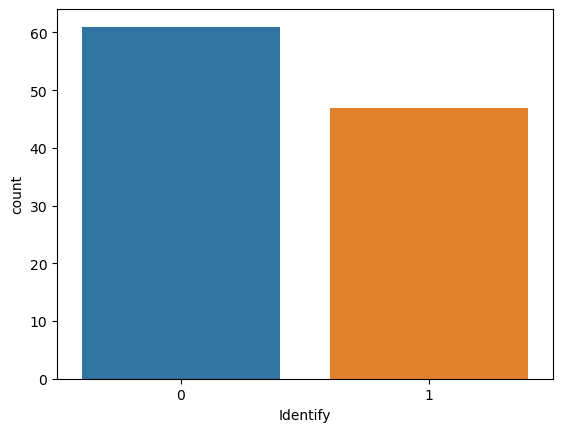

In [641]:
print("Successfull application",df_model[df_model.Identify==0].Identify.count())
print("Failure",df_model[df_model.Identify==1].Identify.count())
sns.countplot(data=df_model, x='Identify')

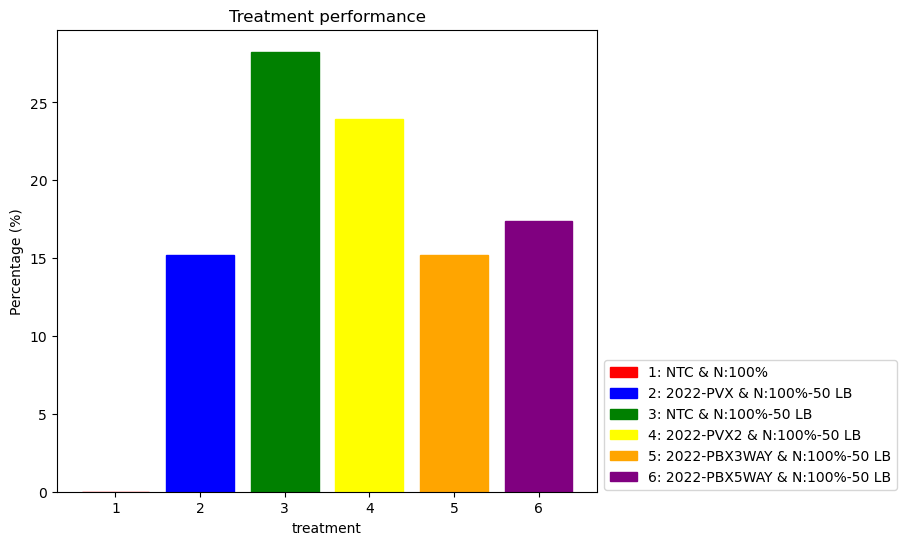

In [269]:
count_df = df_v3_get.groupby(['treatment'])['Identify'].sum().reset_index()
count_df['Percentage'] = (count_df['Identify'] / count_df['Identify'].sum()) * 100

type_meanings = {'1': 'NTC & N:100%', '2': '2022-PVX & N:100%-50 LB', '3': 'NTC & N:100%-50 LB', '4': '2022-PVX2 & N:100%-50 LB', '5': '2022-PBX3WAY & N:100%-50 LB', '6': '2022-PBX5WAY & N:100%-50 LB'}
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']


plt.figure(figsize=(8, 6))
bars = plt.bar(count_df['treatment'], count_df['Percentage'])

for i, bar in enumerate(bars):
    bar.set_color(colors[i])
    
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = [f"{type_}: {meaning}" for type_, meaning in type_meanings.items()]
plt.legend(legend_handles, legend_labels,loc='upper left', bbox_to_anchor=(1, 0.3))

plt.xlabel('treatment')
plt.ylabel('Percentage (%)')
plt.title('Treatment performance')
plt.subplots_adjust(right=0.8)
plt.show()

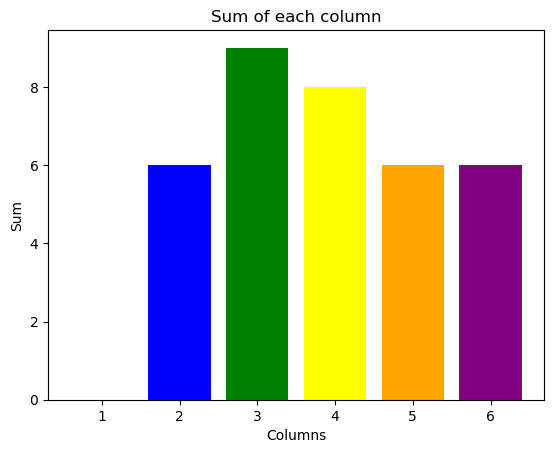

In [800]:
# treatment=['1', '2', '3','4', '5', '6']
column_sums=df_model_v3[df_model_v3.Identify==1][['1', '2', '3','4', '5', '6']].sum()
# Plot the column sums as a bar figure
bar_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']
plt.bar(column_sums.index, column_sums.values,color=bar_colors)
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.title('Sum of each column')
plt.show()

# Modelling

In [11]:
model_names=[]
###for training
accuracys1=[]
precisions1=[]
recalls1=[]
f1s1=[]
roc_aucs1=[]
pr_aucs1=[]
###for testing
accuracys2=[]
precisions2=[]
recalls2=[]
f1s2=[]
roc_aucs2=[]
pr_aucs2=[]

###for validation
pr_aucs3=[]

In [13]:
print(df_model_v3.shape)
# print(df_model_v4.shape)
# print(df_model_v6.shape)

(120, 36)


In [14]:
df_model_v3=df_model_v3.dropna()
train_raw, test_raw = train_test_split(df_model_v3,test_size=0.2, random_state=0)

In [15]:
train_raw.columns

Index(['trial_id', 'latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '2', '3',
       '4', '5', '6', 'Identify'],
      dtype='object')

In [16]:
features = ['latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d','1',
       '2', '3', '4', '5', '6', 'Identify']

target = 'Identify'
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]

X_test = test_raw[features]
y_test = test_raw[target]

In [17]:
def add_print_metrics1(model_idx, y, y_pred, y_proba):
    accuracys1.append(accuracy_score(y, y_pred))
    precisions1.append(precision_score(y, y_pred))
    recalls1.append(recall_score(y, y_pred))
    f1s1.append(f1_score(y, y_pred))
    roc_aucs1.append(metrics.roc_auc_score(y, y_proba[:,1]))
    pr_aucs1.append(average_precision_score(y,y_proba[:,1]))
    print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Precision score is {precision_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Recall score is {recall_score(y, y_pred)}")
    print(f"{model_names[model_idx]} F1 score is {f1_score(y, y_pred)}")
    
    print(f"{model_names[model_idx]} ROC-AUC score is {metrics.roc_auc_score(y, y_proba[:,1])}")
    print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y,y_proba[:,1])}")
    
def add_print_metrics2(model_idx, y, y_pred, y_proba):
    accuracys2.append(accuracy_score(y, y_pred))
    precisions2.append(precision_score(y, y_pred))
    recalls2.append(recall_score(y, y_pred))
    f1s2.append(f1_score(y, y_pred))
    roc_aucs2.append(metrics.roc_auc_score(y, y_proba[:,1]))
    pr_aucs2.append(average_precision_score(y,y_proba[:,1]))
    print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Precision score is {precision_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Recall score is {recall_score(y, y_pred)}")
    print(f"{model_names[model_idx]} F1 score is {f1_score(y, y_pred)}")
    
    print(f"{model_names[model_idx]} ROC-AUC score is {metrics.roc_auc_score(y, y_proba[:,1])}")
    print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y,y_proba[:,1])}")

In [18]:
# as this is an imbalanced dataset, we use PR-AUC as the evaluation metris in training
scorer = make_scorer(average_precision_score, greater_is_better = True)

<font size = '4'> <font color= 'blue'>
    Model----LogisticRegression
<font>

In [19]:
model_names.append('LR_v3')

In [20]:
#### with amp
steps = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model = Pipeline(steps)

params = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun = GridSearchCV(estimator = model, param_grid = params, scoring = scorer, cv = 5,error_score="raise")

model_tun = model_tun.fit(X_train, y_train)

print('The best parameters finally chose are',model_tun.best_params_)
print('The ROC_AUC score from these parameters is',model_tun.best_score_)

pr_aucs3.append(model_tun.best_score_)

y_train_pred_lr=model_tun.best_estimator_.predict(X_train)
y_train_proba_lr = model_tun.best_estimator_.predict_proba(X_train)

y_test_pred_lr=model_tun.best_estimator_.predict(X_test)
y_test_proba_lr = model_tun.best_estimator_.predict_proba(X_test)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(0,y_train,y_train_pred_lr,y_train_proba_lr)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(0,y_test,y_test_pred_lr,y_test_proba_lr)

The best parameters finally chose are {'lr__C': 100, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.6453174603174603
-------------------------Train dataset Result------------------------------
LR_v3 Accuracy score is 0.9375
LR_v3 Precision score is 0.9032258064516129
LR_v3 Recall score is 0.9333333333333333
LR_v3 F1 score is 0.9180327868852459
LR_v3 ROC-AUC score is 0.9946666666666667
LR_v3 PR-AUC score is 0.9918040060851927
-------------------------Test dataset Result------------------------------
LR_v3 Accuracy score is 0.6
LR_v3 Precision score is 0.36363636363636365
LR_v3 Recall score is 0.8
LR_v3 F1 score is 0.5000000000000001
LR_v3 ROC-AUC score is 0.8133333333333334
LR_v3 PR-AUC score is 0.7057142857142857


In [22]:
confusion_matrix(y_test, y_test_pred_lr)

array([[8, 7],
       [1, 4]], dtype=int64)

Confusion Matrix:
[[8 7]
 [1 4]]


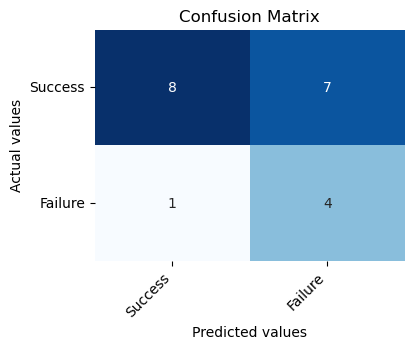

In [23]:
cm = confusion_matrix(y_test, y_test_pred_lr)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

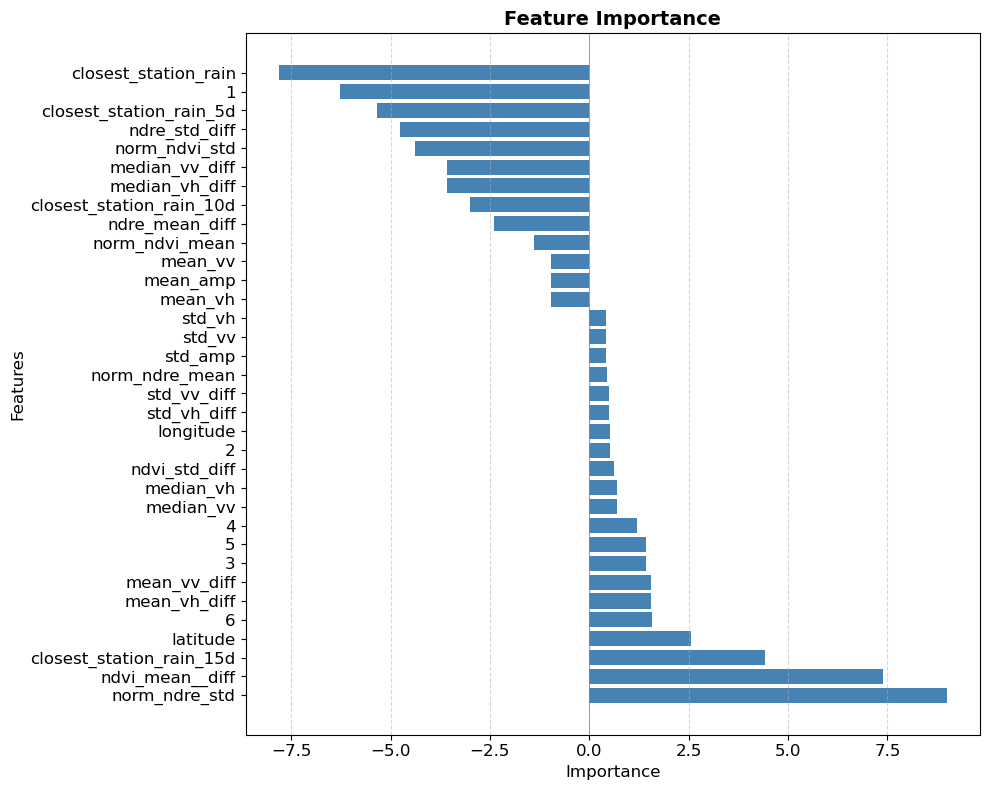

In [798]:
coefficients = model_tun.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
# plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

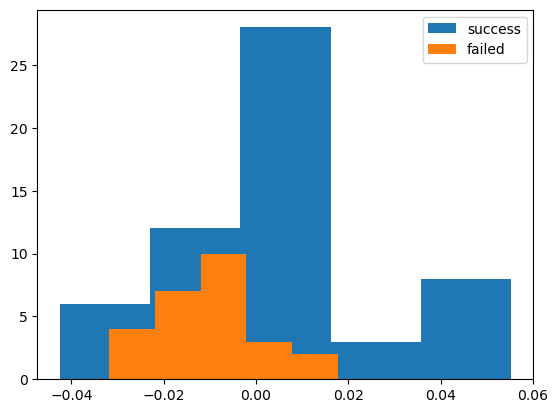

In [369]:
plt.hist(df_model[df_model['Identify']==0].ndre_mean_diff,label='success',bins=5)
plt.hist(df_model[df_model['Identify']==1].ndre_mean_diff,label='failed',bins=5)
plt.legend()

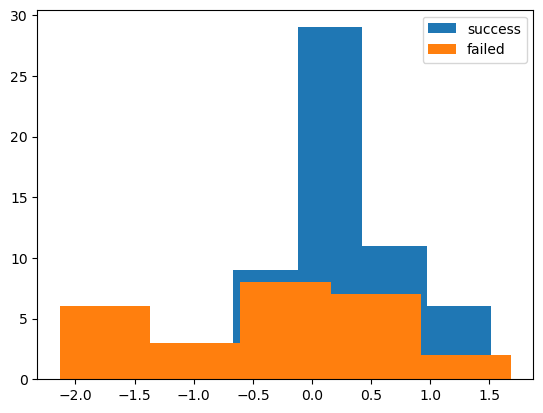

In [372]:
plt.hist(df_model[df_model['Identify']==0].median_vv_diff,label='success',bins=5)
plt.hist(df_model[df_model['Identify']==1].median_vv_diff,label='failed',bins=5)
plt.legend()

In [341]:
df_position=df_model[df_model.Identify==1][['longitude','latitude']]
df_position['longitude']=df_position['longitude']-360
print(df_position.count())

longitude    26
latitude     26
dtype: int64


In [359]:
tmp=df_model[df_model.Identify==1].groupby('trial_id').agg({'Identify':'count'}).reset_index()
tmp['percent'] =round(tmp.Identify/tmp.Identify.sum(),3)
tmp

trial_id  Identify  percent
0  22-ZEAMX-US501-IA01-5FELDM         3    0.115
1   22-ZEAMX-US501-IA02-5GAUL         2    0.077
2  22-ZEAMX-US501-IA04-5HANSE         5    0.192
3   22-ZEAMX-US501-IL02-5WADE         2    0.077
4  22-ZEAMX-US501-IL03-5JONES         5    0.192
5   22-ZEAMX-US501-IN01-5GOHN         2    0.077
6  22-ZEAMX-US501-IN03-5SMITH         2    0.077
7    22-ZEAMX-US501-MO01-5DYE         3    0.115
8  22-ZEAMX-US501-ND01-5PETER         2    0.077

In [360]:
7.7+38.5+11.5+26.9+15.4

100.0

In [339]:
# # import cartopy.crs as ccrs

# # Create a new map with WGS 1984 projection
# projection = ccrs.PlateCarree()
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=projection)

# # Draw coastlines
# ax.coastlines()

# # Plotting points on the map
# # ax.plot(df_position.longitude, df_position.latitude, 'ro', markersize=5, transform=projection)

# # Show the map
# plt.show()

In [343]:
df_position.to_csv('for_plot_latlong.csv',index=None)

In [298]:
compare=pd.DataFrame(y_test)
compare.columns=['Real']
compare['Predict']=y_test_pred_lr

Confusion Matrix:
[[9 8]
 [1 7]]


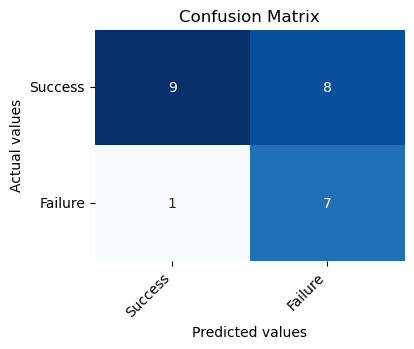

In [299]:
cm = confusion_matrix(y_test, y_test_pred_lr)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# for i in range(len(class_labels)):
#     for j in range(len(class_labels)):
#         ax.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color='black')

# for i in range(len(class_labels)):
#     TP = cm[i, i]
#     FP = np.sum(cm[:, i]) - TP
#     TN = np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + TP
#     FN = np.sum(cm[i, :]) - TP

#     ax.text(len(class_labels) + 0.5, i + 0.5, f'TP: {TP}', ha='left', va='center', color='green')
#     ax.text(len(class_labels) + 1.5, i + 0.5, f'FP: {FP}', ha='left', va='center', color='red')
#     ax.text(len(class_labels) + 3.0, i + 0.5, f'TN: {TN}', ha='left', va='center', color='green')
#     ax.text(len(class_labels) + 4.5, i + 0.5, f'FN: {FN}', ha='left', va='center', color='red')
    
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

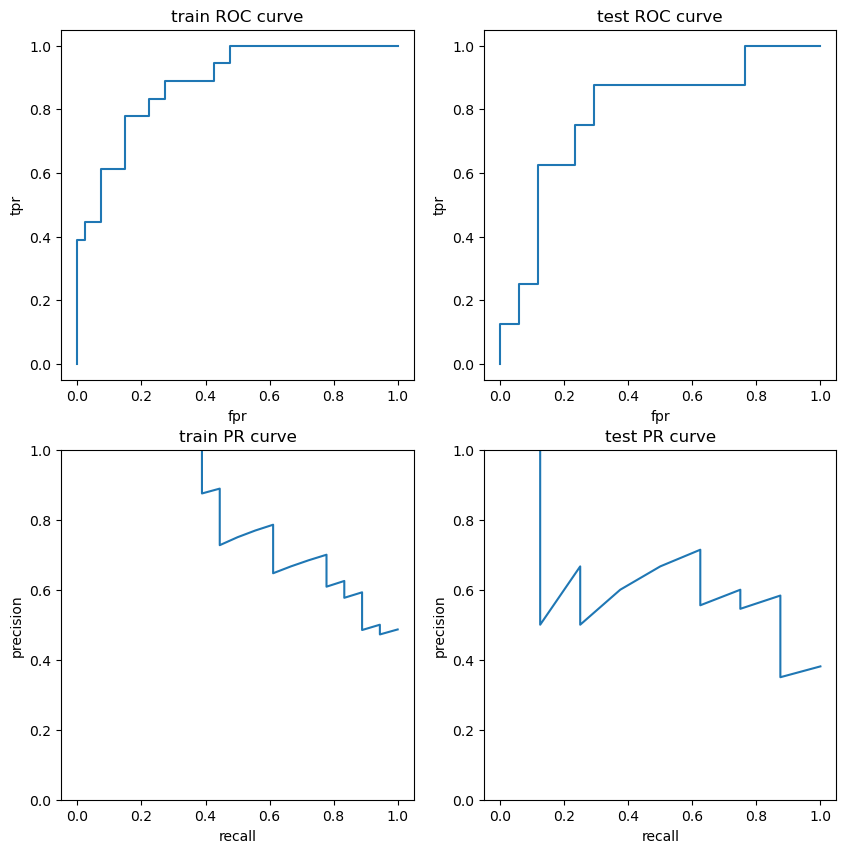

In [300]:
# plot ROC curve and PR curve

fpr, tpr, th = roc_curve(y_train, y_train_proba_lr[:, 1])
fpr1, tpr1, th1 = roc_curve(y_test, y_test_proba_lr[:, 1])

precision, recall, threshold = precision_recall_curve(y_train, y_train_proba_lr [:,1])
precision1, recall1, threshold1 = precision_recall_curve(y_test, y_test_proba_lr [:,1])

fig, axe = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(10)

axe[0, 0].plot(fpr, tpr)
axe[0, 0].set_xlabel('fpr')
axe[0, 0].set_ylabel('tpr')
axe[0, 0].set_title('train ROC curve')

axe[0, 1].plot(fpr1, tpr1)
axe[0, 1].set_xlabel('fpr')
axe[0, 1].set_ylabel('tpr')
axe[0, 1].set_title('test ROC curve')

axe[1, 0].plot(recall, precision)
axe[1, 0].set_xlabel('recall')
axe[1, 0].set_ylabel('precision')
axe[1, 0].set_title('train PR curve')
axe[1, 0].set_ylim(0, 1)


axe[1, 1].plot(recall1, precision1)
axe[1, 1].set_xlabel('recall')
axe[1, 1].set_ylabel('precision')
axe[1, 1].set_title('test PR curve')
axe[1, 1].set_ylim(0, 1)


plt.show()

In [277]:
df_all.stage.unique()

array(['V0', 'VE', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V10', 'V11',
       'V12', 'VT', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R6+', 'V9', 'V8'],
      dtype=object)

<font size = '4'> <font color= 'blue'>
    (2) Model2----Super Vector Machine
<font>

In [547]:
from sklearn.svm import SVC

In [650]:
steps2 = [('rescale', StandardScaler()),
        ('svc', SVC(kernel='linear', probability=True))]

model2 = Pipeline(steps2)

params2= {'svc__kernel': ['rbf'], 
#           'svc__C': [0.1, 1, 10],
          'svc__C': [0.1,1,10,100,1000],
         'svc__gamma': [0.1, 1, 10]}

model2_tun = GridSearchCV(estimator = model2, param_grid = params2, scoring = scorer, cv = 5)

model2_tun = model2_tun.fit(X_train, y_train)

print('The best parameters finally chose are',model2_tun.best_params_)
print('The ROC_AUC  score from these parameters is',model2_tun.best_score_)

The best parameters finally chose are {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
The ROC_AUC  score from these parameters is 0.4958333333333333


In [651]:
y_train_pred_svc=model2_tun.best_estimator_.predict(X_train)
y_train_proba_svc = model2_tun.best_estimator_.predict_proba(X_train)

y_test_pred_svc=model2_tun.best_estimator_.predict(X_test)
y_test_proba_svc = model2_tun.best_estimator_.predict_proba(X_test)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(1,y_train,y_train_pred_svc,y_train_proba_svc)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(1,y_test,y_test_pred_svc,y_test_proba_svc)

-------------------------Train dataset Result------------------------------


IndexError: list index out of range

### Weather background - precipitation

In [452]:
### load the downloaded weather station data
weather=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\weather\station_weather.csv')

In [454]:
print(weather.shape)
weather.head(2)

(717974, 9)


STATION                     NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  US1IAST0048  BETTENDORF 1.6 W, IA US  41.56502  -90.50767      211.8   
1  US1IAST0048  BETTENDORF 1.6 W, IA US  41.56502  -90.50767      211.8   

         DATE  PRCP PRCP_ATTRIBUTES state  
0  2022-05-11   0.0             ,,N    IA  
1  2022-05-23   0.0             ,,N    IA

In [ ]:
weather['PRCP']=weather.PRCP.fillna(0)

In [239]:
df1['flight_date']=df_merge3[df_merge3.ndvi_mean.notnull()]['flight_date']

In [455]:
df1.head(2)

plot                    trial_id  treatment  \
0   206  22-ZEAMX-US501-IA01-5FELDM          1   
1   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                            geometry  \
0  POLYGON ((-93.62044187504478 41.86379593747736...   
1  POLYGON ((-93.62044187504478 41.86379593747736...   

                             GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
0  41.86343116382189,-93.62011715769768   0.329640  0.126840   0.154118   
1  41.86343116382189,-93.62011715769768   0.390106  0.088408   0.373614   

   ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
0  0.131604    V0  255.082905 -22.621263 -22.445223  2.110355 -22.621263   
1  0.090695    V0  255.082905 -22.621263 -22.445223  2.110355 -22.621263   

   median_vv    std_vv flight_date  
0 -22.445223  2.110355  2022-06-01  
1 -22.445223  2.110355  2022-06-02

In [241]:
# Convert the flight date column to datetime
df1['flight_date'] = pd.to_datetime(df1['flight_date']).dt.date
weather['DATE'] = pd.to_datetime(weather['DATE']).dt.date

In [ ]:
# df_v3=df_all[df_all.stage=='V3']
df_v3=df1[df_all.stage=='V3']

###  Select stage V4 to test

In [397]:
df_all=df_merge3[['plot','trial_id','treatment','flight_date','geometry','GPS_center','ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std','stage',
       'yield']]

df_all['geometry']=df_all['geometry'].apply(lambda x: wkt.loads(x) if x else None)

print(df_all.shape)

(20526, 12)


In [45]:
# df_v3=df_all[df_all.stage=='V3']
df_v4=df_all[df_all.stage=='V4']

In [437]:
### Get the boundary of each trial to cut the downloaed HyP3 tiff files
######################################################################

tmp=df_v4.groupby(['trial_id']).agg({'geometry': unary_union})
tmp=tmp.reset_index()

# Extract boundaries for each polygon in trial
tmp['upper_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[3])
tmp['lower_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[1])
tmp['left_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[0])
tmp['right_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[2])

# get a rectangle boundary for later extraction of the SAR image
tmp['outline']=tmp.apply(lambda row: Polygon([(row['left_boundary'], row['lower_boundary']),
                                               (row['right_boundary'], row['lower_boundary']),
                                               (row['right_boundary'], row['upper_boundary']),
                                               (row['left_boundary'], row['upper_boundary'])]),
                           axis=1)
                         
### save a file to 
tmp[['trial_id','left_boundary', 'right_boundary','lower_boundary','upper_boundary']].to_csv('boundarys_V4.csv',header=None,index=None)

### save all shp files
output_folder = r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\all_shps\stageV4'

# Convert the drao a GeoDataFrame

gdf1 = gpd.GeoDataFrame(tmp, geometry='outline')

# Iterate over each row in the GeoDataFrame
for index, row in gdf1.iterrows():
    id_value = row['trial_id']
    outline_geom = row['outline']
    
    # Create a new GeoDataFrame for the current polygon
    poly_gdf = gpd.GeoDataFrame({'geometry': [outline_geom]}, crs=gdf.crs)
    
    # Save the polygon to a shapefile using the ID as the filename
    output_filename = os.path.join(output_folder, f'{id_value}.shp')
    poly_gdf.to_file(output_filename)

In [48]:
####### RESAMPLE THE IMAGE TO FINER RESOLUTION
################################################################################################################

# ### folder to store the cut images
input_path = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif\stage4"

#### folder to store the resample images
output_path= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif\stage41"

for file in os.listdir(input_path):
    
    file_path=os.path.join(input_path,file)

    src = rasterio.open(file_path)

    # Calculate the new dimensions and resolution
    new_resolution = (0.00001, -0.00001)  # New resolution in meters
    new_width = src.width * src.transform.a / new_resolution[0]
    new_height = src.height * src.transform.e / new_resolution[1]

    # Create the output TIFF file with the new dimensions and resolution
    
#     output_file = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif2\output.tif"

    
    prefix=file.split(".")[0]
    output_file = os.path.join(output_path, f"{prefix}_resample.tif")
    
    
    dst_transform = Affine(new_resolution[0], 0, src.transform.c, 0, new_resolution[1], src.transform.f)
    dst_profile = src.profile
    dst_profile.update(transform=dst_transform, width=int(new_width), height=int(new_height))

    # Perform the resampling
    with rasterio.open(output_file, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src.crs,  # Assuming the same CRS
                resampling=rasterio.enums.Resampling.bilinear
            )

In [49]:
print(df_v4.shape)
df_v4.head(2)

(546, 12)


plot                    trial_id  treatment  \
11   206  22-ZEAMX-US501-IA01-5FELDM          1   
12   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry flight_date  \
11  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-22   
12  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-23   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
11  41.86343116382189,-93.62011715769768   0.686095  0.048791   0.568864   
12  41.86343116382189,-93.62011715769768   0.524783  0.060322   0.404171   

    ndre_std stage       yield  
11  0.056934    V4  255.082905  
12  0.065189    V4  255.082905

In [50]:
def extract_statistics(image_path, polygon):
    stats = zonal_stats(polygon, image_path, stats=['mean', 'median', 'std'])
    mean_value = stats[0]['mean']
    median_value = stats[0]['median']
    std_value = stats[0]['std']
    return mean_value, median_value, std_value

In [51]:
input_tif_folder= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif\stage41"
cnt=0

######
for index, row in df_v4.iterrows():
    cnt+=1
    print(cnt)
    id_value = row['trial_id']
    image_path_VH = os.path.join(input_tif_folder,f'{id_value}_VH_resample.tif')
    image_path_VV = os.path.join(input_tif_folder,f'{id_value}_VV_resample.tif')

    # Check if the TIF image exists
    if os.path.exists(image_path_VH) and os.path.exists(image_path_VV):
        # Extract the polygon from the 'geometry' column
        polygon = row['geometry']

        # Extract the statistics from the image within the polygon
        mean_vh, median_vh, std_vh = extract_statistics(image_path_VH, polygon)
        mean_vv, median_vv, std_vv = extract_statistics(image_path_VH, polygon)

        # Update the dataframe with the statistics
        df_v4.at[index, 'mean_vh'] = mean_vh
        df_v4.at[index, 'median_vh'] = median_vh
        df_v4.at[index, 'std_vh'] = std_vh
        df_v4.at[index, 'mean_vv'] = mean_vv
        df_v4.at[index, 'median_vv'] = median_vv
        df_v4.at[index, 'std_vv'] = std_vv
    else:
        # TIF image doesn't exist, set the values as NaN
        df_v4.at[index, 'mean_vh'] = np.nan
        df_v4.at[index, 'median_vh'] = np.nan
        df_v4.at[index, 'std_vh'] = np.nan
        df_v4.at[index, 'mean_vv'] = np.nan
        df_v4.at[index, 'median_vv'] = np.nan
        df_v4.at[index, 'std_vv'] = np.nan

# Save the updated dataframe
# df.to_csv('output.csv', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [450]:
df_v4.head(2)

plot                    trial_id  treatment flight_date  \
11   206  22-ZEAMX-US501-IA01-5FELDM          1  2022-06-22   
12   206  22-ZEAMX-US501-IA01-5FELDM          1  2022-06-23   

                                             geometry  \
11  POLYGON ((-93.62044187504478 41.86379593747736...   
12  POLYGON ((-93.62044187504478 41.86379593747736...   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
11  41.86343116382189,-93.62011715769768   0.686095  0.048791   0.568864   
12  41.86343116382189,-93.62011715769768   0.524783  0.060322   0.404171   

    ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
11  0.056934    V4  255.082905 -22.621263 -22.445223  2.110355 -22.621263   
12  0.065189    V4  255.082905 -22.621263 -22.445223  2.110355 -22.621263   

    median_vv    std_vv  
11 -22.445223  2.110355  
12 -22.445223  2.110355

In [52]:
df_v4.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'flight_date',
       'GPS_center', 'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage',
       'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv',
       'std_vv'],
      dtype='object')

#### Get weather

In [53]:
# Convert the flight date column to datetime
df_v4['flight_date'] = pd.to_datetime(df_v4['flight_date']).dt.date
weather['DATE'] = pd.to_datetime(weather['DATE']).dt.date

In [54]:
def find_closest_point_to_centroid(polygon_geom, points_df):
    # Extract the polygon geometry from the DataFrame
#     polygon_geom = polygon_df['geometry'].iloc[0]

    # Calculate the centroid of the polygon
    centroid = polygon_geom.centroid

    closest_point = None
    min_distance = float('inf')

    # Iterate through the DataFrame of points
    for _, point in points_df.iterrows():
        point_lat = point['LATITUDE']
        point_lon = point['LONGITUDE']
        rain_value = point['PRCP']

        # Create a Shapely Point object from the latitude and longitude
        point_geom = Point(point_lon, point_lat)

        # Calculate the distance between the point and the centroid
        distance = centroid.distance(point_geom)

        # Update the closest point and rain value if a closer point is found
        if distance < min_distance:
            min_distance = distance
            closest_point = point
            closest_point['PRCP'] = rain_value

    return closest_point

In [55]:
def cal_rolling_sums(station,given_date,window_size):
    df_select=weather[weather.STATION==station]
    df_select=df_select.sort_values('DATE')
    df_select.set_index('DATE', inplace=True)
    rolling_sum = df_select['PRCP'].rolling(window=window_size, min_periods=window_size).sum().loc[given_date]
    return rolling_sum

In [56]:
# df_v3['geometry']=df_v3['geometry'].apply(lambda x: wkt.loads(x) if x else None)
cnt=0
for index, row in df_v4.iterrows():
    cnt+=1
    print(cnt)
    # Extract ID, geometry, and flight date from the current row
    ID = row['trial_id']
    geometry = row['geometry']
    flight_date = row['flight_date']
#     print(flight_date)

    # Filter the weather archive dataframe based on the flight date
    filtered_weather_df = weather[weather['DATE'] == flight_date]
    
    # Find the point closest to the centroid of the polygon
    if not filtered_weather_df.empty:
        closest_point = find_closest_point_to_centroid(geometry, filtered_weather_df)

        # Retrieve the rain and elevation values for the closest weather station
        closest_station_rain = closest_point['PRCP']
        closest_station_rain_5d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],5)
        closest_station_rain_10d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],10)
        closest_station_rain_15d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],15)
        
#         closest_station_elevation = closest_point['ELEVATION']

        # Add the rain and elevation values as new columns in the original dataframe
        df_v4.at[index, 'closest_station_rain'] = closest_station_rain
        df_v4.at[index, 'closest_station_rain_5d'] = closest_station_rain_5d
        df_v4.at[index, 'closest_station_rain_10d'] = closest_station_rain_10d
        df_v4.at[index, 'closest_station_rain_15d'] = closest_station_rain_15d
        
#         df_v4.at[index, 'closest_station_elevation'] = closest_station_elevation
    else:
#         print(index,ID,flight_date)
        df_v4.at[index, 'closest_station_rain'] = np.nan
        df_v4.at[index, 'closest_station_rain_5d'] = np.nan
        df_v4.at[index, 'closest_station_rain_10d'] = np.nan
        df_v4.at[index, 'closest_station_rain_15d'] = np.nan
#         df_v4.at[index, 'closest_station_elevation'] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [468]:
# df_v4=df_v4.drop(columns=['closest_station_elevation'])

In [57]:
df_v4.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'flight_date',
       'GPS_center', 'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage',
       'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv',
       'std_vv', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d'],
      dtype='object')

In [58]:
df_v4_get=df_v4.groupby(['trial_id','treatment']).agg({'ndvi_mean':'mean','ndvi_std':'mean','ndre_mean':'mean','ndre_std':'mean','yield':'mean',
                                             'mean_vh':'mean','median_vh':'mean', 'std_vh':'mean', 'mean_vv':'mean', 'median_vv':'mean', 'std_vv':'mean',
                                             'closest_station_rain':'mean','closest_station_rain_5d':'mean',
                                               'closest_station_rain_10d':'mean', 'closest_station_rain_15d':'mean',
                                                       'geometry': unary_union})
df_v4_get=df_v4_get.reset_index()

In [59]:
df_v4_get.isnull().sum()

trial_id                     0
treatment                    0
ndvi_mean                    0
ndvi_std                     0
ndre_mean                    0
ndre_std                     0
yield                        0
mean_vh                     18
median_vh                   18
std_vh                      18
mean_vv                     18
median_vv                   18
std_vv                      18
closest_station_rain         0
closest_station_rain_5d      0
closest_station_rain_10d     0
closest_station_rain_15d     0
geometry                     0
dtype: int64

## EDA

#### Add latitude and longitude as features

In [61]:
get_centroid=df_v4_get[['geometry']]
gdf = gpd.GeoDataFrame(get_centroid, geometry='geometry')
# Compute the centroid of each polygon
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroid
df_v4_get['latitude']=gdf.centroid.y
df_v4_get['longitude'] = gdf.centroid.x

In [62]:
df_v4_get['longitude']=df_v4_get['longitude']+360

#### NDRE and NDVI

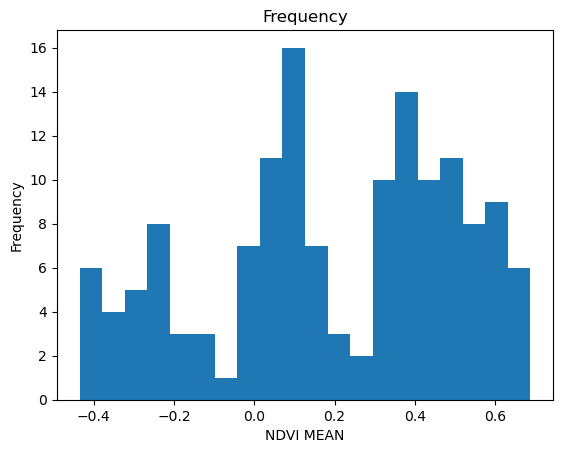

In [63]:
df_v4_get.ndvi_mean.plot(kind='hist',bins=20)
plt.xlabel('NDVI MEAN')
plt.title('Frequency')
plt.show()

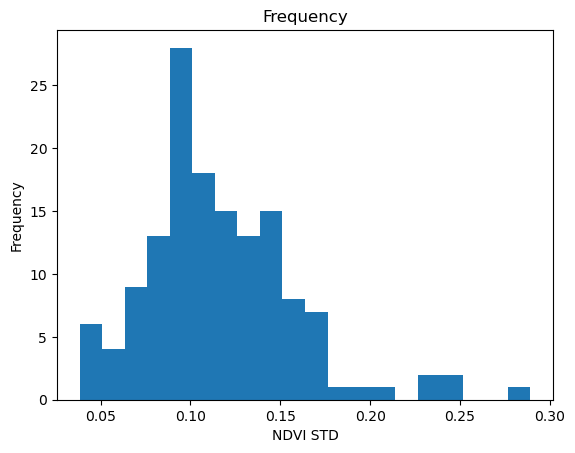

In [476]:
df_v4_get.ndvi_std.plot(kind='hist',bins=20)
plt.xlabel('NDVI STD')
plt.title('Frequency')
plt.show()

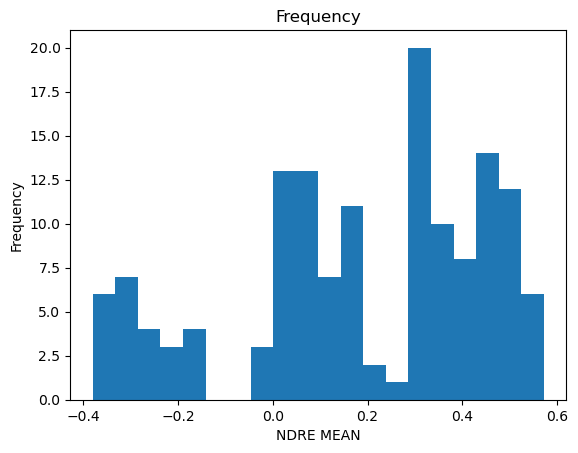

In [477]:
df_v4_get.ndre_mean.plot(kind='hist',bins=20)
plt.xlabel('NDRE MEAN')
plt.title('Frequency')
plt.show()

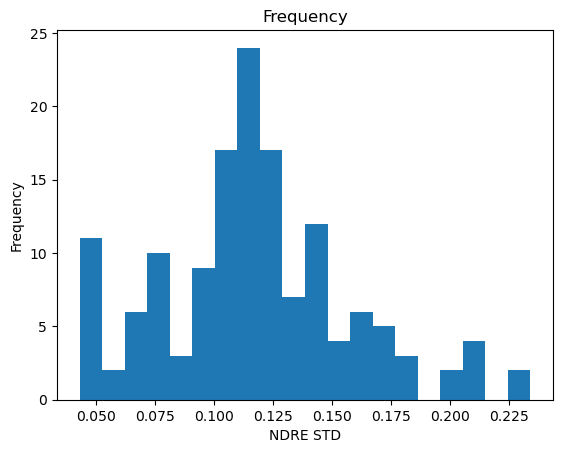

In [478]:
df_v4_get.ndre_std.plot(kind='hist',bins=20)
plt.xlabel('NDRE STD')
plt.title('Frequency')
plt.show()

In [64]:
scaler = MinMaxScaler()

df_v4_get['norm_ndvi_mean'] = scaler.fit_transform(df_v4_get[['ndvi_mean']])
df_v4_get['norm_ndvi_std'] = scaler.fit_transform(df_v4_get[['ndvi_std']].values)
df_v4_get['norm_ndre_mean'] = scaler.fit_transform(df_v4_get[['ndre_mean']].values)
df_v4_get['norm_ndre_std'] = scaler.fit_transform(df_v4_get[['ndre_std']].values)

#### treatment

In [65]:
treat_encoder = OneHotEncoder(handle_unknown='ignore')
treat_onehot=treat_encoder.fit_transform(df_v4[['treatment']])
treatments=pd.DataFrame(treat_onehot.toarray())

In [66]:
all_treatments=treat_encoder.categories_[0]
for i in range(len(all_treatments)):
    df_v4_get[str(all_treatments[i])]=treatments.iloc[:,i]

In [67]:
trials=df_v4_get['trial_id'].tolist()
yields=df_v4_get['yield'].tolist()

Identifys=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v4_get[(df_v4_get['trial_id'] == trail_id) & (df_v4_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0
    Identifys.append(check)

In [68]:
df_v4_get['Identify'] = Identifys

#### Get more features - compare with treatment 1 condition

In [69]:
df_v4_get['ndvi_mean__diff'] = df_v4_get.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_v4_get['ndvi_std_diff'] = df_v4_get.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_v4_get['ndre_mean_diff'] = df_v4_get.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_v4_get['ndre_std_diff'] = df_v4_get.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [70]:
df_v4_get['mean_amp']=(df_v4_get['mean_vh']+df_v4_get['mean_vv'])/2
df_v4_get['std_amp']=(df_v4_get['std_vh']+df_v4_get['std_vv'])/2

df_v4_get['mean_vh_diff'] = df_v4_get.groupby('trial_id')['mean_vh'].transform(lambda x: x - x.iloc[0])
df_v4_get['median_vh_diff'] = df_v4_get.groupby('trial_id')['median_vh'].transform(lambda x: x - x.iloc[0])
df_v4_get['std_vh_diff'] = df_v4_get.groupby('trial_id')['std_vh'].transform(lambda x: x - x.iloc[0])
df_v4_get['mean_vv_diff'] = df_v4_get.groupby('trial_id')['mean_vv'].transform(lambda x: x - x.iloc[0])
df_v4_get['median_vv_diff'] = df_v4_get.groupby('trial_id')['median_vv'].transform(lambda x: x - x.iloc[0])
df_v4_get['std_vv_diff'] = df_v4_get.groupby('trial_id')['std_vv'].transform(lambda x: x - x.iloc[0])

In [42]:
### save all data in case
df_v4_get.to_csv('df_v4_get_incase.csv',index=None)

In [24]:
df_v4_get=pd.read_csv('df_v4_get_incase.csv')

In [25]:
df_v4_get.shape

(144, 43)

In [41]:
df_v4_get.columns

Index(['trial_id', 'treatment', 'ndvi_mean', 'ndvi_std', 'ndre_mean',
       'ndre_std', 'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'closest_station_rain',
       'closest_station_rain_5d', 'closest_station_rain_10d',
       'closest_station_rain_15d', 'geometry', 'latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       '1', '2', '3', '4', '5', '6', 'Identify', 'ndvi_mean__diff',
       'ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff', 'mean_amp',
       'std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff',
       'mean_vv_diff', 'median_vv_diff', 'std_vv_diff', 'Identify2'],
      dtype='object')

In [28]:
trials=df_v4_get['trial_id'].tolist()
yields=df_v4_get['yield'].tolist()

Identifys2=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v4_get[(df_v4_get['trial_id'] == trail_id) & (df_v4_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0
    Identifys2.append(check)

df_v4_get['Identify2'] = Identifys2

*******************************************************************************************************

In [26]:
### get the columns fro modeling
df_model_v4=df_v4_get[['trial_id','latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       'ndvi_mean__diff','ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '2', '3', '4', '5', '6','Identify']]

Successfull application 57
Failure 70


<AxesSubplot:xlabel='Identify', ylabel='count'>

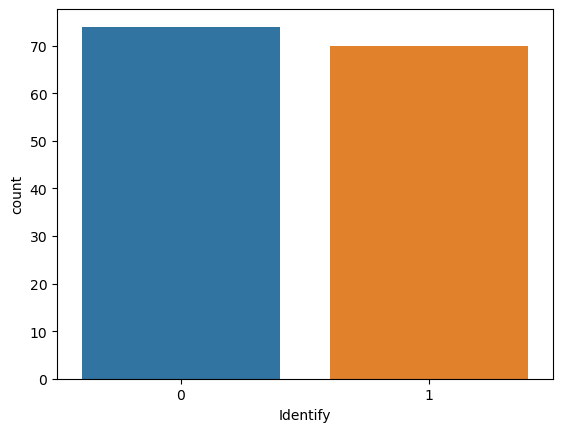

In [672]:
print("Successfull application",df_model[df_model_v4.Identify==0].Identify.count())
print("Failure",df_model_v4[df_model_v4.Identify==1].Identify.count())
sns.countplot(data=df_model_v4, x='Identify')

# Modelling

In [27]:
df_model_v4=df_model_v4.dropna()
train_raw, test_raw = train_test_split(df_model_v4,test_size=0.2, random_state=0)

In [28]:
train_raw.columns

Index(['trial_id', 'latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '2', '3',
       '4', '5', '6', 'Identify'],
      dtype='object')

In [29]:
features = ['latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff','std_vv_diff',
       'closest_station_rain', 'closest_station_rain_5d','closest_station_rain_10d', 'closest_station_rain_15d',
            '1','2', '3', '4', '5', '6', 'Identify']

target = 'Identify'
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]

X_test = test_raw[features]
y_test = test_raw[target]

<font size = '4'> <font color= 'blue'>
    Model----LogisticRegression
<font>

In [30]:
model_names.append('LR_v4')

In [31]:
#### with amp
steps = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model = Pipeline(steps)

params = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun = GridSearchCV(estimator = model, param_grid = params, scoring = scorer, cv = 5,error_score="raise")

model_tun = model_tun.fit(X_train, y_train)

print('The best parameters finally chose are',model_tun.best_params_)
print('The ROC_AUC score from these parameters is',model_tun.best_score_)

pr_aucs3.append(model_tun.best_score_)

y_train_pred_lr=model_tun.best_estimator_.predict(X_train)
y_train_proba_lr = model_tun.best_estimator_.predict_proba(X_train)

y_test_pred_lr=model_tun.best_estimator_.predict(X_test)
y_test_proba_lr = model_tun.best_estimator_.predict_proba(X_test)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(0,y_train,y_train_pred_lr,y_train_proba_lr)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(0,y_test,y_test_pred_lr,y_test_proba_lr)

The best parameters finally chose are {'lr__C': 10, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.6230194805194805
-------------------------Train dataset Result------------------------------
LR_v3 Accuracy score is 0.83
LR_v3 Precision score is 0.8235294117647058
LR_v3 Recall score is 0.84
LR_v3 F1 score is 0.8316831683168315
LR_v3 ROC-AUC score is 0.9128000000000001
LR_v3 PR-AUC score is 0.919288283295546
-------------------------Test dataset Result------------------------------
LR_v3 Accuracy score is 0.48
LR_v3 Precision score is 0.42105263157894735
LR_v3 Recall score is 0.8
LR_v3 F1 score is 0.5517241379310345
LR_v3 ROC-AUC score is 0.6866666666666666
LR_v3 PR-AUC score is 0.7108118096737022


Confusion Matrix:
[[ 4 11]
 [ 2  8]]


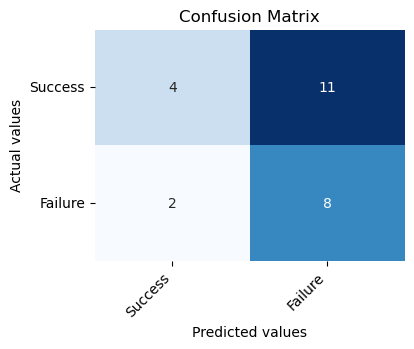

In [32]:
cm = confusion_matrix(y_test, y_test_pred_lr)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

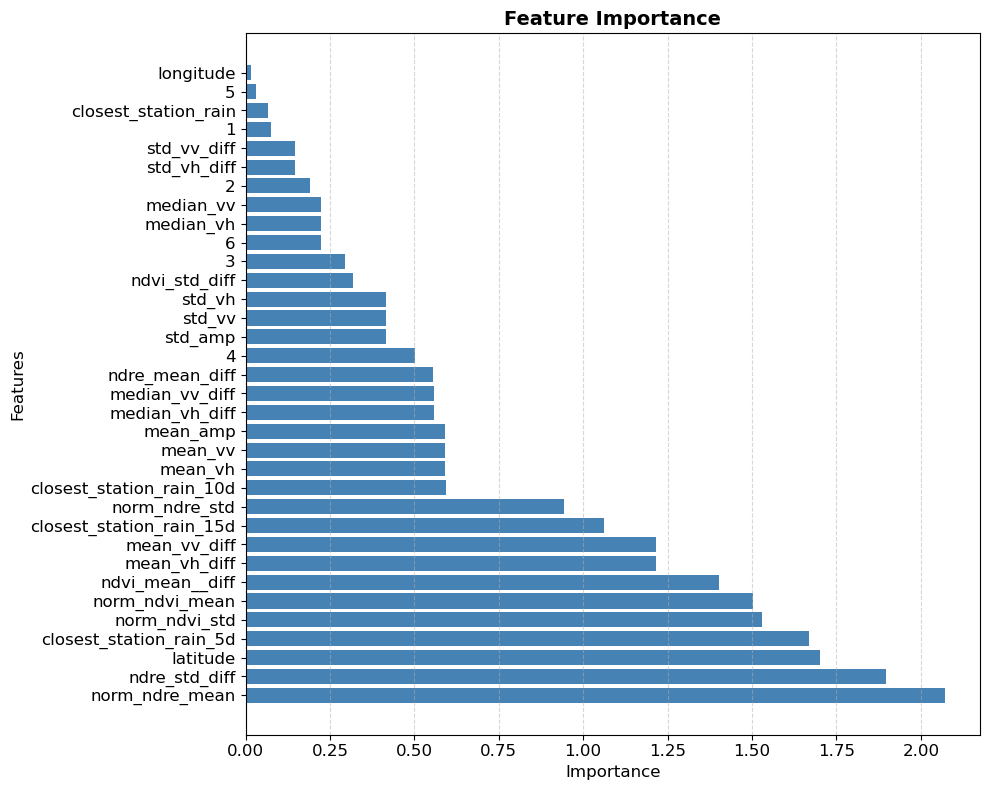

In [742]:
coefficients = model_tun.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
# plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

###  Stage V6

In [72]:
# df_v3=df_all[df_all.stage=='V3']
df_v6=df_all[df_all.stage=='V6']

In [503]:
print(df_v6.shape)
df_v6.head(2)

(384, 12)


plot                    trial_id  treatment flight_date  \
15   206  22-ZEAMX-US501-IA01-5FELDM          1  2022-06-28   
16   206  22-ZEAMX-US501-IA01-5FELDM          1  2022-06-29   

                                             geometry  \
15  POLYGON ((-93.62044187504478 41.86379593747736...   
16  POLYGON ((-93.62044187504478 41.86379593747736...   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
15  41.86343116382189,-93.62011715769768   0.746925  0.061096   0.598701   
16  41.86343116382189,-93.62011715769768   0.808155  0.045634   0.706146   

    ndre_std stage       yield  
15  0.073183    V6  255.082905  
16  0.059622    V6  255.082905

In [439]:
### Get the boundary of each trial
######################################################################

tmp=df_v6.groupby(['trial_id']).agg({'geometry': unary_union})
tmp=tmp.reset_index()

# Extract boundaries for each polygon in trial
tmp['upper_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[3])
tmp['lower_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[1])
tmp['left_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[0])
tmp['right_boundary'] = tmp['geometry'].apply(lambda mp: mp.bounds[2])

# get a rectangle boundary for later extraction of the SAR image
tmp['outline']=tmp.apply(lambda row: Polygon([(row['left_boundary'], row['lower_boundary']),
                                               (row['right_boundary'], row['lower_boundary']),
                                               (row['right_boundary'], row['upper_boundary']),
                                               (row['left_boundary'], row['upper_boundary'])]),
                           axis=1)
                         
### save a file to 
tmp[['trial_id','left_boundary', 'right_boundary','lower_boundary','upper_boundary']].to_csv('boundarys_V6.csv',header=None,index=None)

# ### save all shp files
# output_folder = r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\all_shps\stageV6'

# # Convert the drao a GeoDataFrame

# gdf1 = gpd.GeoDataFrame(tmp, geometry='outline')

# # Iterate over each row in the GeoDataFrame
# for index, row in gdf1.iterrows():
#     id_value = row['trial_id']
#     outline_geom = row['outline']
    
#     # Create a new GeoDataFrame for the current polygon
#     poly_gdf = gpd.GeoDataFrame({'geometry': [outline_geom]}, crs=gdf.crs)
    
#     # Save the polygon to a shapefile using the ID as the filename
#     output_filename = os.path.join(output_folder, f'{id_value}.shp')
#     poly_gdf.to_file(output_filename)

In [73]:
####### RESAMPLE THE IMAGE TO FINER RESOLUTION
################################################################################################################

# ### folder to store the cut images
input_path = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif\stage6"

#### folder to store the resample images
output_path= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif\stage61"

for file in os.listdir(input_path):
    
    file_path=os.path.join(input_path,file)

    src = rasterio.open(file_path)

    # Calculate the new dimensions and resolution
    new_resolution = (0.00001, -0.00001)  # New resolution in meters
    new_width = src.width * src.transform.a / new_resolution[0]
    new_height = src.height * src.transform.e / new_resolution[1]

    # Create the output TIFF file with the new dimensions and resolution
    
#     output_file = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif2\output.tif"

    
    prefix=file.split(".")[0]
    output_file = os.path.join(output_path, f"{prefix}_resample.tif")
    
    
    dst_transform = Affine(new_resolution[0], 0, src.transform.c, 0, new_resolution[1], src.transform.f)
    dst_profile = src.profile
    dst_profile.update(transform=dst_transform, width=int(new_width), height=int(new_height))

    # Perform the resampling
    with rasterio.open(output_file, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src.crs,  # Assuming the same CRS
                resampling=rasterio.enums.Resampling.bilinear
            )

In [74]:
input_tif_folder= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif\stage61"
cnt=0

######
for index, row in df_v6.iterrows():
    cnt+=1
    print(cnt)
    id_value = row['trial_id']
    image_path_VH = os.path.join(input_tif_folder,f'{id_value}_VH_resample.tif')
    image_path_VV = os.path.join(input_tif_folder,f'{id_value}_VV_resample.tif')

    # Check if the TIF image exists
    if os.path.exists(image_path_VH) and os.path.exists(image_path_VV):
        # Extract the polygon from the 'geometry' column
        polygon = row['geometry']

        # Extract the statistics from the image within the polygon
        mean_vh, median_vh, std_vh = extract_statistics(image_path_VH, polygon)
        mean_vv, median_vv, std_vv = extract_statistics(image_path_VH, polygon)

        # Update the dataframe with the statistics
        df_v6.at[index, 'mean_vh'] = mean_vh
        df_v6.at[index, 'median_vh'] = median_vh
        df_v6.at[index, 'std_vh'] = std_vh
        df_v6.at[index, 'mean_vv'] = mean_vv
        df_v6.at[index, 'median_vv'] = median_vv
        df_v6.at[index, 'std_vv'] = std_vv
    else:
        # TIF image doesn't exist, set the values as NaN
        df_v6.at[index, 'mean_vh'] = np.nan
        df_v6.at[index, 'median_vh'] = np.nan
        df_v6.at[index, 'std_vh'] = np.nan
        df_v6.at[index, 'mean_vv'] = np.nan
        df_v6.at[index, 'median_vv'] = np.nan
        df_v6.at[index, 'std_vv'] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [75]:
print(df_v6.shape)
df_v6.head(2)

(384, 18)


plot                    trial_id  treatment  \
15   206  22-ZEAMX-US501-IA01-5FELDM          1   
16   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry flight_date  \
15  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-28   
16  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-29   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
15  41.86343116382189,-93.62011715769768   0.746925  0.061096   0.598701   
16  41.86343116382189,-93.62011715769768   0.808155  0.045634   0.706146   

    ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
15  0.073183    V6  255.082905 -22.679659 -22.520973  2.195205 -22.679659   
16  0.059622    V6  255.082905 -22.679659 -22.520973  2.195205 -22.679659   

    median_vv    std_vv  
15 -22.520973  2.195205  
16 -22.520973  2.195205

In [76]:
df_v6.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'flight_date',
       'GPS_center', 'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage',
       'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv',
       'std_vv'],
      dtype='object')

#### Get weather

In [77]:
# Convert the flight date column to datetime
df_v6['flight_date'] = pd.to_datetime(df_v6['flight_date']).dt.date
weather['DATE'] = pd.to_datetime(weather['DATE']).dt.date

In [78]:
cnt=0

for index, row in df_v6.iterrows():
    cnt+=1
    print(cnt)
    # Extract ID, geometry, and flight date from the current row
    ID = row['trial_id']
    geometry = row['geometry']
    flight_date = row['flight_date']
#     print(flight_date)

    # Filter the weather archive dataframe based on the flight date
    filtered_weather_df = weather[weather['DATE'] == flight_date]
    
    # Find the point closest to the centroid of the polygon
    if not filtered_weather_df.empty:
        closest_point = find_closest_point_to_centroid(geometry, filtered_weather_df)

        # Retrieve the rain and elevation values for the closest weather station
        closest_station_rain = closest_point['PRCP']
        closest_station_rain_5d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],5)
        closest_station_rain_10d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],10)
        closest_station_rain_15d = cal_rolling_sums(closest_point['STATION'],closest_point['DATE'],15)
        
#         closest_station_elevation = closest_point['ELEVATION']

        # Add the rain and elevation values as new columns in the original dataframe
        df_v6.at[index, 'closest_station_rain'] = closest_station_rain
        df_v6.at[index, 'closest_station_rain_5d'] = closest_station_rain_5d
        df_v6.at[index, 'closest_station_rain_10d'] = closest_station_rain_10d
        df_v6.at[index, 'closest_station_rain_15d'] = closest_station_rain_15d
    
#         df_v6.at[index, 'closest_station_elevation'] = closest_station_elevation
    else:
#         print(index,ID,flight_date)
        df_v6.at[index, 'closest_station_rain'] = np.nan
        df_v6.at[index, 'closest_station_rain_5d'] = np.nan
        df_v6.at[index, 'closest_station_rain_10d'] = np.nan
        df_v6.at[index, 'closest_station_rain_15d'] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [79]:
df_v6.head(2)

plot                    trial_id  treatment  \
15   206  22-ZEAMX-US501-IA01-5FELDM          1   
16   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry flight_date  \
15  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-28   
16  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-29   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
15  41.86343116382189,-93.62011715769768   0.746925  0.061096   0.598701   
16  41.86343116382189,-93.62011715769768   0.808155  0.045634   0.706146   

    ndre_std  ...    mean_vh  median_vh    std_vh    mean_vv  median_vv  \
15  0.073183  ... -22.679659 -22.520973  2.195205 -22.679659 -22.520973   
16  0.059622  ... -22.679659 -22.520973  2.195205 -22.679659 -22.520973   

      std_vv  closest_station_rain  closest_station_rain_5d  \
15  2.195205                   0.0                     0.21   
16  2.195205                   0.0                     0.21   

    closest_station_rain_10d  closest_station_rain_15d  
15                      0.21                      0.34  
16                      0.21                      0.34  

[2 rows x 22 columns]

In [683]:
df_v6.columns

Index(['plot', 'trial_id', 'treatment', 'flight_date', 'geometry',
       'GPS_center', 'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage',
       'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv',
       'std_vv', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d'],
      dtype='object')

In [80]:
df_v6_get=df_v6.groupby(['trial_id','treatment']).agg({'ndvi_mean':'mean','ndvi_std':'mean','ndre_mean':'mean','ndre_std':'mean','yield':'mean',
                                             'mean_vh':'mean','median_vh':'mean', 'std_vh':'mean', 'mean_vv':'mean', 'median_vv':'mean', 'std_vv':'mean',
                                             'closest_station_rain':'mean','closest_station_rain_5d':'mean','closest_station_rain_10d':'mean',
                                            'closest_station_rain_15d':'mean','geometry': unary_union})
df_v6_get=df_v6_get.reset_index()

In [81]:
df_v6_get.isnull().sum()

trial_id                    0
treatment                   0
ndvi_mean                   0
ndvi_std                    0
ndre_mean                   0
ndre_std                    0
yield                       0
mean_vh                     6
median_vh                   6
std_vh                      6
mean_vv                     6
median_vv                   6
std_vv                      6
closest_station_rain        0
closest_station_rain_5d     0
closest_station_rain_10d    0
closest_station_rain_15d    0
geometry                    0
dtype: int64

## EDA

#### Add latitude and longitude as features

In [82]:
get_centroid=df_v6_get[['geometry']]
gdf = gpd.GeoDataFrame(get_centroid, geometry='geometry')
# Compute the centroid of each polygon
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroid
df_v6_get['latitude']=gdf.centroid.y
df_v6_get['longitude'] = gdf.centroid.x

In [83]:
df_v6_get['longitude']=df_v6_get['longitude']+360

#### NDRE and NDVI

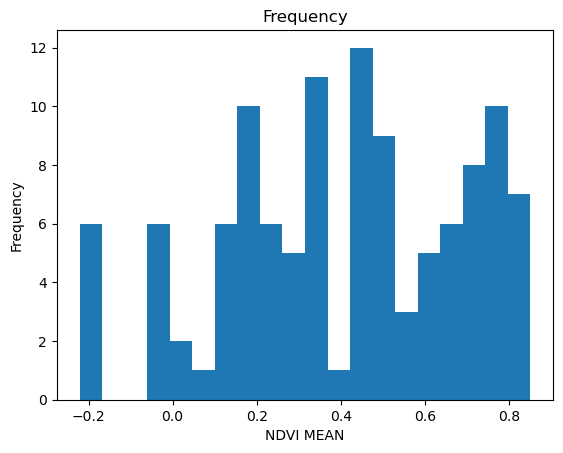

In [84]:
df_v6_get.ndvi_mean.plot(kind='hist',bins=20)
plt.xlabel('NDVI MEAN')
plt.title('Frequency')
plt.show()

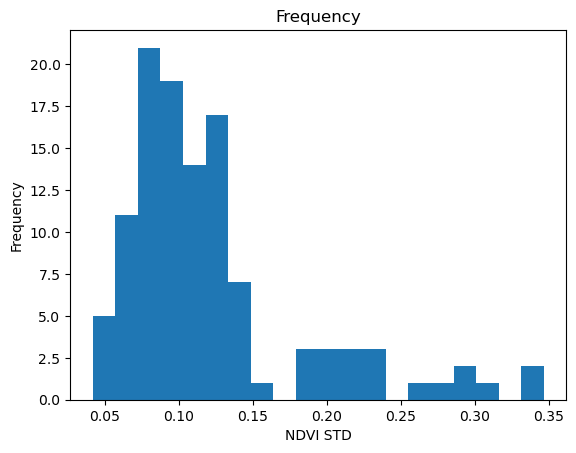

In [518]:
df_v6_get.ndvi_std.plot(kind='hist',bins=20)
plt.xlabel('NDVI STD')
plt.title('Frequency')
plt.show()

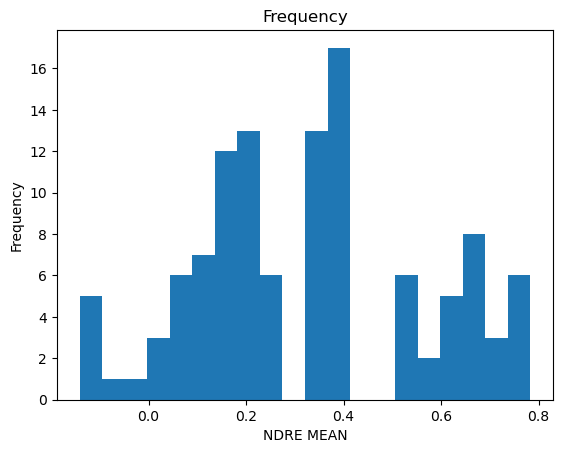

In [519]:
df_v6_get.ndre_mean.plot(kind='hist',bins=20)
plt.xlabel('NDRE MEAN')
plt.title('Frequency')
plt.show()

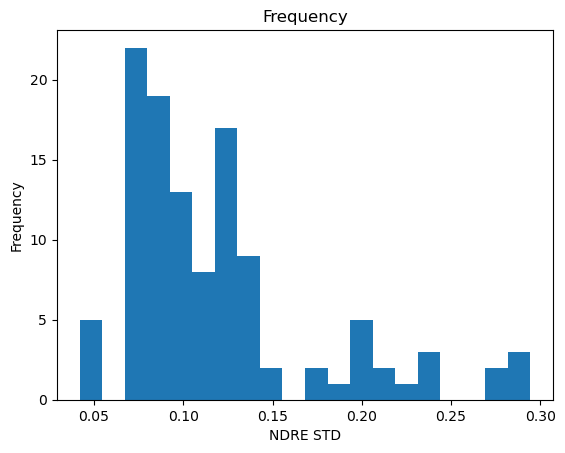

In [520]:
df_v6_get.ndre_std.plot(kind='hist',bins=20)
plt.xlabel('NDRE STD')
plt.title('Frequency')
plt.show()

In [85]:
scaler = MinMaxScaler()

df_v6_get['norm_ndvi_mean'] = scaler.fit_transform(df_v6_get[['ndvi_mean']])
df_v6_get['norm_ndvi_std'] = scaler.fit_transform(df_v6_get[['ndvi_std']].values)
df_v6_get['norm_ndre_mean'] = scaler.fit_transform(df_v6_get[['ndre_mean']].values)
df_v6_get['norm_ndre_std'] = scaler.fit_transform(df_v6_get[['ndre_std']].values)

#### treatment

In [86]:
treat_encoder = OneHotEncoder(handle_unknown='ignore')
treat_onehot=treat_encoder.fit_transform(df_v6[['treatment']])
treatments=pd.DataFrame(treat_onehot.toarray())

In [87]:
all_treatments=treat_encoder.categories_[0]
for i in range(len(all_treatments)):
    df_v6_get[str(all_treatments[i])]=treatments.iloc[:,i]

In [88]:
trials=df_v6_get['trial_id'].tolist()
yields=df_v6_get['yield'].tolist()

Identifys=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v6_get[(df_v6_get['trial_id'] == trail_id) & (df_v6_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0
    Identifys.append(check)

In [89]:
df_v6_get['Identify'] = Identifys

#### Get more features - compare with treatment 1 condition

In [90]:
df_v6_get['ndvi_mean__diff'] = df_v6_get.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_v6_get['ndvi_std_diff'] = df_v6_get.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_v6_get['ndre_mean_diff'] = df_v6_get.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_v6_get['ndre_std_diff'] = df_v6_get.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [91]:
df_v6_get['mean_amp']=(df_v6_get['mean_vh']+df_v6_get['mean_vv'])/2
df_v6_get['std_amp']=(df_v6_get['std_vh']+df_v6_get['std_vv'])/2

df_v6_get['mean_vh_diff'] = df_v6_get.groupby('trial_id')['mean_vh'].transform(lambda x: x - x.iloc[0])
df_v6_get['median_vh_diff'] = df_v6_get.groupby('trial_id')['median_vh'].transform(lambda x: x - x.iloc[0])
df_v6_get['std_vh_diff'] = df_v6_get.groupby('trial_id')['std_vh'].transform(lambda x: x - x.iloc[0])
df_v6_get['mean_vv_diff'] = df_v6_get.groupby('trial_id')['mean_vv'].transform(lambda x: x - x.iloc[0])
df_v6_get['median_vv_diff'] = df_v6_get.groupby('trial_id')['median_vv'].transform(lambda x: x - x.iloc[0])
df_v6_get['std_vv_diff'] = df_v6_get.groupby('trial_id')['std_vv'].transform(lambda x: x - x.iloc[0])

In [47]:
### save all data in case
df_v6_get.to_csv('df_v6_get_incase.csv',index=None)

In [43]:
df_v6_get=pd.read_csv('df_v6_get_incase.csv')

In [44]:
df_v6_get.shape

(114, 43)

In [45]:
df_v6_get.columns

Index(['trial_id', 'treatment', 'ndvi_mean', 'ndvi_std', 'ndre_mean',
       'ndre_std', 'yield', 'mean_vh', 'median_vh', 'std_vh', 'mean_vv',
       'median_vv', 'std_vv', 'closest_station_rain',
       'closest_station_rain_5d', 'closest_station_rain_10d',
       'closest_station_rain_15d', 'geometry', 'latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       '1', '2', '3', '4', '5', '6', 'Identify', 'ndvi_mean__diff',
       'ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff', 'mean_amp',
       'std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff',
       'mean_vv_diff', 'median_vv_diff', 'std_vv_diff'],
      dtype='object')

In [46]:
trials=df_v6_get['trial_id'].tolist()
yields=df_v6_get['yield'].tolist()

Identifys2=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v6_get[(df_v6_get['trial_id'] == trail_id) & (df_v6_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if yie - reference < (reference * -0.03) else 0
    Identifys2.append(check)
    
df_v6_get['Identify2'] = Identifys2

*******************************************************************************************************

In [95]:
### get the columns fro modeling
df_model_v6=df_v6_get[['trial_id','latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       'ndvi_mean__diff','ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_rain_5d', 'closest_station_rain_10d','closest_station_rain_15d',
        '1', '2', '3', '4', '5', '6','Identify']]

Successfull application 62
Failure 47


<AxesSubplot:xlabel='Identify', ylabel='count'>

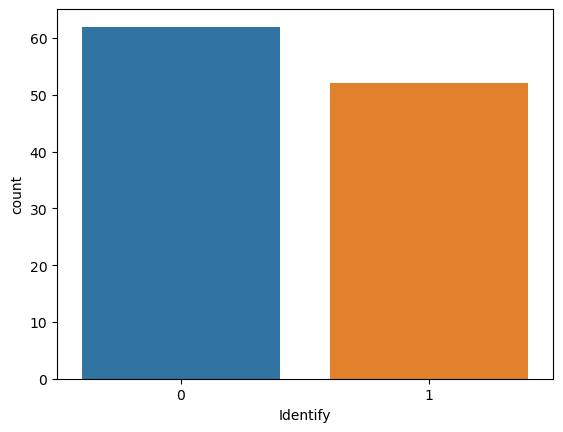

In [699]:
print("Successfull application",df_model_v6[df_model_v6.Identify==0].Identify.count())
print("Failure",df_model[df_model_v6.Identify==1].Identify.count())
sns.countplot(data=df_model_v6, x='Identify')

# Modelling

In [36]:
df_model_v6=df_model_v6.dropna()
train_raw, test_raw = train_test_split(df_model_v6,test_size=0.2, random_state=0)

In [37]:
train_raw.columns

Index(['trial_id', 'latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_rain_5d',
       'closest_station_rain_10d', 'closest_station_rain_15d', '1', '2', '3',
       '4', '5', '6', 'Identify'],
      dtype='object')

In [38]:
features = ['latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain','closest_station_rain_5d',
            'closest_station_rain_10d', 'closest_station_rain_15d',
        '1','2', '3', '4', '5', '6', 'Identify']

target = 'Identify'
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]

X_test = test_raw[features]
y_test = test_raw[target]

<font size = '4'> <font color= 'blue'>
    Model----LogisticRegression
<font>

In [39]:
model_names.append('LR_v6')

In [40]:
#### with amp
steps = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model = Pipeline(steps)

params = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun = GridSearchCV(estimator = model, param_grid = params, scoring = scorer, cv = 5,error_score="raise")

model_tun = model_tun.fit(X_train, y_train)

print('The best parameters finally chose are',model_tun.best_params_)
print('The ROC_AUC score from these parameters is',model_tun.best_score_)
pr_aucs3.append(model_tun.best_score_)

y_train_pred_lr=model_tun.best_estimator_.predict(X_train)
y_train_proba_lr = model_tun.best_estimator_.predict_proba(X_train)

y_test_pred_lr=model_tun.best_estimator_.predict(X_test)
y_test_proba_lr = model_tun.best_estimator_.predict_proba(X_test)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(0,y_train,y_train_pred_lr,y_train_proba_lr)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(0,y_test,y_test_pred_lr,y_test_proba_lr)

The best parameters finally chose are {'lr__C': 100, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.5523272642390289
-------------------------Train dataset Result------------------------------
LR_v3 Accuracy score is 0.813953488372093
LR_v3 Precision score is 0.775
LR_v3 Recall score is 0.8157894736842105
LR_v3 F1 score is 0.7948717948717949
LR_v3 ROC-AUC score is 0.9353070175438596
LR_v3 PR-AUC score is 0.9215888824512888
-------------------------Test dataset Result------------------------------
LR_v3 Accuracy score is 0.6818181818181818
LR_v3 Precision score is 0.5714285714285714
LR_v3 Recall score is 0.8888888888888888
LR_v3 F1 score is 0.6956521739130435
LR_v3 ROC-AUC score is 0.7948717948717949
LR_v3 PR-AUC score is 0.6980460410284972


Confusion Matrix:
[[7 6]
 [1 8]]


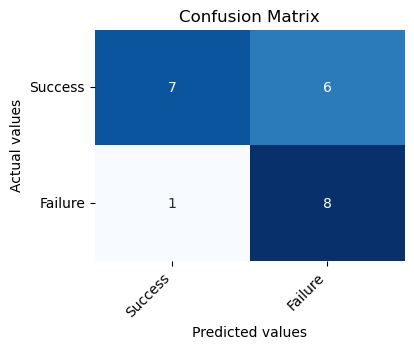

In [41]:
cm = confusion_matrix(y_test, y_test_pred_lr)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)  
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

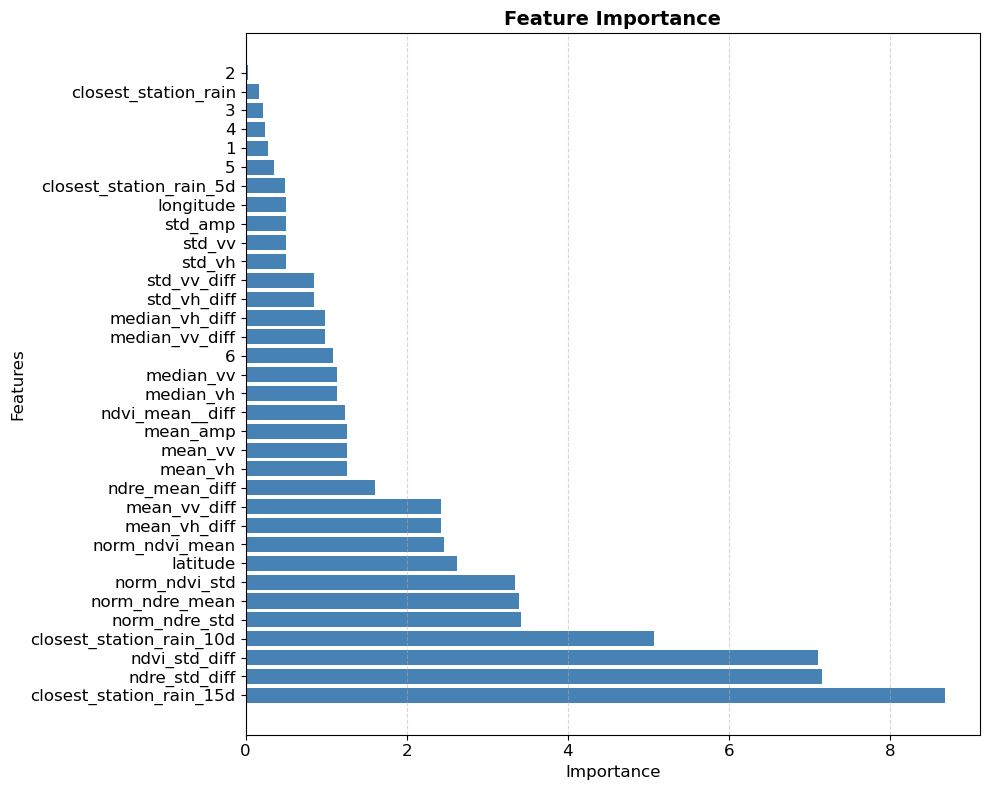

In [748]:
coefficients = model_tun.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
# plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [779]:
data = {"model": model_names,
        "train_accuracy": accuracys1,
        "test_accuracy": accuracys2,
        "train_precision": precisions1,
        "test_precision": precisions2,
        "train_recall": recalls1,
        "test_recall": recalls2,
        "train_F1": f1s1,
        "test_F1": f1s2,
        "train_ROC_AUC": roc_aucs1,
        "test_ROC_AUC": roc_aucs2,
        "train_PR_AUC": pr_aucs1,
        "test_PR_AUC": pr_aucs2,
        "validation_PR_AUC":pr_aucs3
       }

In [753]:
data

{'model': ['LR_v3', 'LR_v4', 'LR_v6'],
 'train_accuracy': [0.9375, 0.83, 0.813953488372093],
 'test_accuracy': [0.6, 0.48, 0.6818181818181818],
 'train_precision': [0.9032258064516129, 0.8235294117647058, 0.775],
 'test_precision': [0.36363636363636365,
  0.42105263157894735,
  0.5714285714285714],
 'train_recall': [0.9333333333333333, 0.84, 0.8157894736842105],
 'test_recall': [0.8, 0.8, 0.8888888888888888],
 'train_f1': [0.9180327868852459, 0.8316831683168315, 0.7948717948717949],
 'test_f1': [0.5000000000000001, 0.5517241379310345, 0.6956521739130435],
 'train_roc_auc': [0.9946666666666667, 0.9128000000000001, 0.9353070175438596],
 'test_roc_auc': [0.8133333333333334, 0.6866666666666666, 0.7948717948717949],
 'train_pr_auc': [0.9918040060851927, 0.919288283295546, 0.9215888824512888],
 'test_pr_auc': [0.7057142857142857, 0.7108118096737022, 0.6980460410284972],
 'validation_pr_auc': [0.6453174603174603,
  0.6230194805194805,
  0.5523272642390289]}

In [762]:
performance

model  train_accuracy  test_accuracy  train_precision  test_precision  \
0  LR_v3        0.937500       0.600000         0.903226        0.363636   
1  LR_v4        0.830000       0.480000         0.823529        0.421053   
2  LR_v6        0.813953       0.681818         0.775000        0.571429   

   train_recall  test_recall  train_f1   test_f1  train_roc_auc  test_roc_auc  \
0      0.933333     0.800000  0.918033  0.500000       0.994667      0.813333   
1      0.840000     0.800000  0.831683  0.551724       0.912800      0.686667   
2      0.815789     0.888889  0.794872  0.695652       0.935307      0.794872   

   train_pr_auc  test_pr_auc  validation_pr_auc  
0      0.991804     0.705714           0.645317  
1      0.919288     0.710812           0.623019  
2      0.921589     0.698046           0.552327

In [778]:
performance=pd.DataFrame(data)
to_get=performance[['model','train_precision','test_precision', 'train_recall', 'test_recall', 'train_f1', 'test_f1', 'train_pr_auc', 'test_pr_auc']].round(2)
to_get.to_csv('performance_comparison.csv',index=None)

In [771]:
import plotly.graph_objects as go

In [777]:
header_style = {'fill': {'color': 'lightblue'}, 'font': {'size': 14}}
cell_style = {'fill': {'color': 'white'}, 'font': {'size': 12}}

# Create a table trace with custom styles
table_trace = go.Table(
    header=dict(values=to_get.columns, fill=header_style['fill'], font=header_style['font']),
    cells=dict(values=to_get.transpose().values.tolist(), fill=cell_style['fill'], font=cell_style['font'])
)

layout = go.Layout(width=1100, height=500)

fig = go.Figure(data=[table_trace], layout=layout)
fig.show()